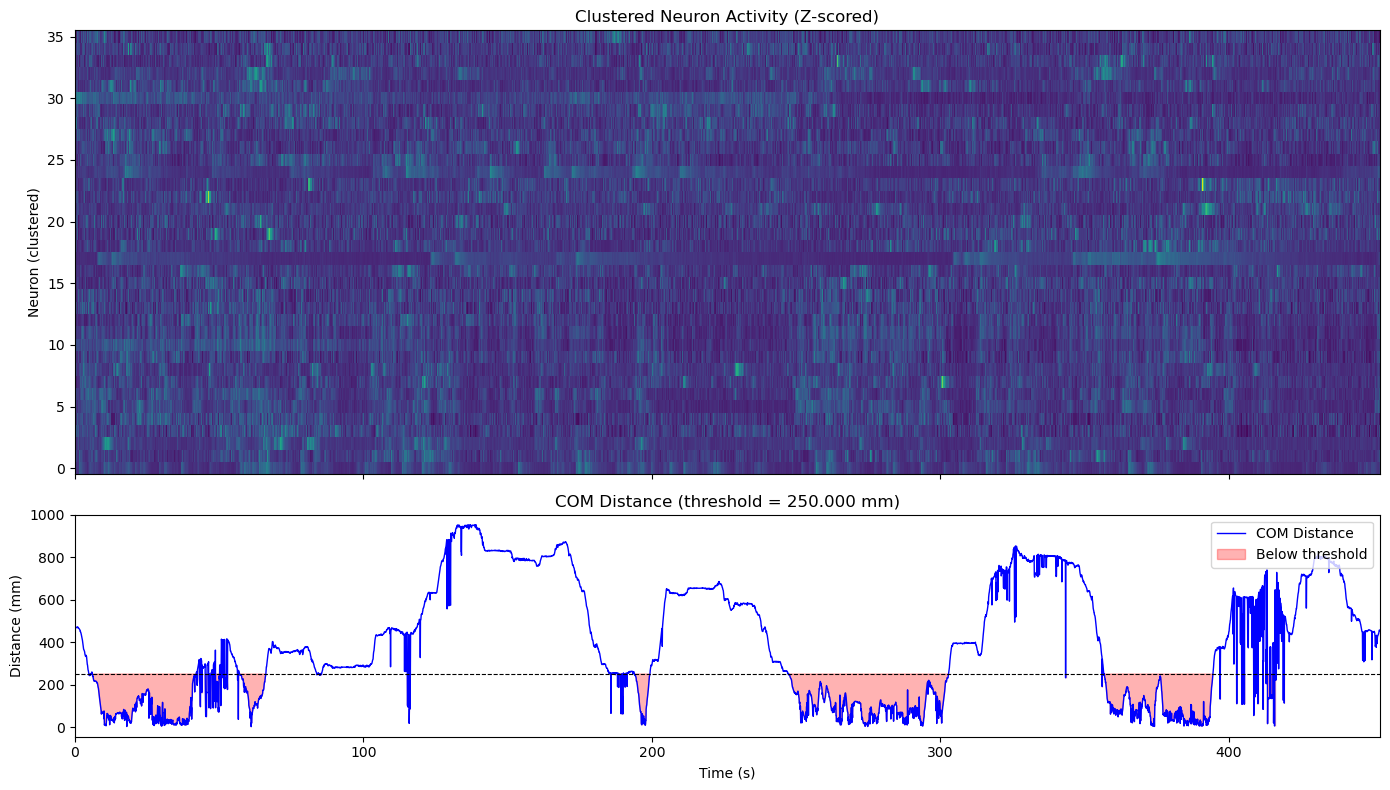

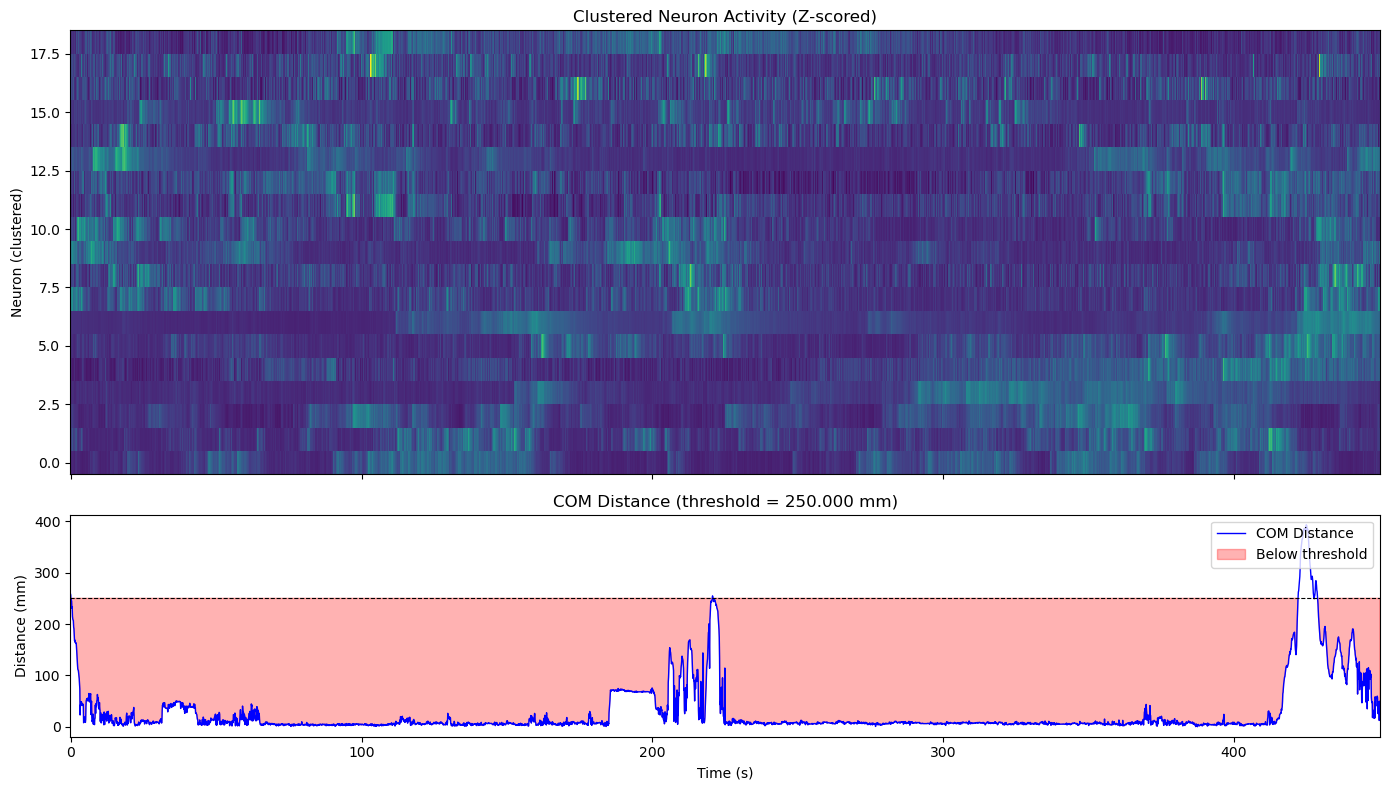

In [6]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果 session_path 在排除字典里，就返回需要排除的神经元索引列表，否则返回空列表。
    """
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    在 rec_path/MIR_Aligned 下寻找匹配的 .h5 文件，将其读入为 DataFrame 并添加一些额外列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')

    # 在这里先不重置 index，因为后续 process_neuron_activity 会返回 df_reset
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    """
    过滤低方差神经元、排除指定索引，并对剩余神经元的 dF/F 序列进行 z-score 标准化。
    返回：
      - normalized: 形状为 (n_kept_neurons, n_timepoints) 的 numpy 数组
      - filtered_cols: 保留下来的列名列表
      - df_reset: 重置了索引的 DataFrame 副本
    """
    # 先重置索引，确保后续按行筛选时不会丢失列
    df_reset = df.reset_index(drop=True)

    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df_reset['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df_reset.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df_reset[neuron_cols].values.T  # shape: (n_neurons, n_timepoints)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)         # 去掉最底部 5% 方差的神经元
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)

    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine（手动设置阈值，优先尝试 com_distances.csv，不存在时仅根据 com_distances_filtered.csv 高亮）
# ---------------------------------------------------------------------------
def plot_cluster_and_distance(df, distance_threshold, exclude_dict=None,
                              manual_exclude_indices=None, apply_exclusion=True):
    """
    绘制：
      1. 聚类后的神经元活动热图（仅保留高方差、不在排除列表的神经元，Z-score 标准化后层次聚类）。
      2. 如果存在 com_distances.csv，加载并绘制原始 COM 距离曲线（单位：秒），并在低于 distance_threshold 时高亮；
         如果 com_distances.csv 缺失但存在 com_distances_filtered.csv，则仅高亮过滤后的帧对应时间。
    参数：
      - df: HDF5 读取后带有 'camera_frame_sixcam' 和 'timestamp_ms_mini' 的 DataFrame
      - distance_threshold: 手动指定的距离阈值（单位与 CSV 一致，比如 mm）
      - exclude_dict: 排除字典，用于 process_neuron_activity
      - manual_exclude_indices: 手动指定排除的 ROI 索引列表
      - apply_exclusion: 是否应用排除逻辑（True/False）
    要求：
      - com_distances.csv 或 com_distances_filtered.csv 必须存在于 rec_path/MIR_Aligned
      - com_distances.csv 如果存在，需包含 'frame' 与 'distance' 两列
      - com_distances_filtered.csv 需包含 'frame' 列
      - HDF5 必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列
    """
    # 第一步：处理神经元活动，得到标准化矩阵和 df_reset
    neuron_norm, neuron_cols, df_reset = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    rec_path = df_reset['session_path'].iloc[0]
    aligned_dir = os.path.join(rec_path, 'MIR_Aligned')
    df_reset = df.reset_index()

    # 检查 HDF5 中是否存在时间列和帧列
    if 'camera_frame_sixcam' not in df_reset.columns or 'timestamp_ms_mini' not in df_reset.columns:
        raise KeyError("HDF5 数据中必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列")
    df_time_map = df_reset[['camera_frame_sixcam', 'timestamp_ms_mini']].drop_duplicates()

    # 尝试加载 com_distances.csv
    com_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
    has_full = os.path.exists(com_csv)

    if has_full:
        # 如果存在 com_distances.csv，则加载并合并时间映射
        df_com = pd.read_csv(com_csv)
        if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
            raise KeyError("com_distances.csv 中必须包含 'frame' 和 'distance' 两列")
        df_com_merged = pd.merge(
            df_com,
            df_time_map,
            left_on='frame',
            right_on='camera_frame_sixcam',
            how='inner'
        )
        # 原始时间（ms）和距离
        times_all_ms = df_com_merged['timestamp_ms_mini'].values
        distances_raw = df_com_merged['distance'].values
        frames_all = df_com_merged['frame'].values.astype(int)

        # 将时间换算成秒
        time_all_s = times_all_ms / 1000.0

        # 根据手动阈值筛选低于阈值的部分
        below_thresh = (distances_raw <= distance_threshold)
        filtered_frames = frames_all[below_thresh]

    else:
        # 如果没有 com_distances.csv，改为检查 com_distances_filtered.csv
        filtered_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
        if not os.path.exists(filtered_csv):
            raise FileNotFoundError(
                f"Cannot find com_distances.csv or com_distances_filtered.csv in {aligned_dir}"
            )
        df_filtered = pd.read_csv(filtered_csv)
        frame_col = df_filtered.columns[0]
        filtered_frames = df_filtered[frame_col].astype(int).values

        # 时间和距离数据无法获取，只占位
        time_all_s = np.array([])
        distances_raw = np.array([])
        below_thresh = np.array([])

    # 在 df_reset 中标记哪些时间点属于低于阈值（或过滤后）的帧
    mask = df_reset['camera_frame_sixcam'].isin(filtered_frames)
    times_mask_ms = df_reset['timestamp_ms_mini'].values
    times_mask_s = times_mask_ms / 1000.0

    # 开始绘图
    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 热图：层次聚类后的 neuron_norm
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        ax_heatmap.pcolormesh(
            times_mask_s if len(times_mask_s)>0 else np.arange(data_ordered.shape[1]),
            np.arange(data_ordered.shape[0]),
            data_ordered,
            cmap='viridis',
            shading='auto'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes, ha='center'
        )
        ax_heatmap.set_ylabel('Neuron (clustered)')
        ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # 第二个子图：COM 距离随时间变化，并在低于阈值时高亮
    if has_full:
        ax_dist.plot(
            time_all_s,
            distances_raw,
            color='blue',
            linewidth=1,
            label='COM Distance'
        )
        ax_dist.set_ylabel('Distance (mm)')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(f'COM Distance (threshold = {distance_threshold:.3f} mm)')

        # 标出低于阈值的部分
        ax_dist.fill_between(
            time_all_s,
            distances_raw,
            distance_threshold,
            where=(distances_raw <= distance_threshold),
            color='red',
            alpha=0.3,
            label='Below threshold'
        )
        # 画出阈值线
        ax_dist.axhline(distance_threshold, color='black', linestyle='--', linewidth=0.8)
        ax_dist.legend(loc='upper right')

    else:
        # 仅存在 filtered CSV 的情况：画一个空白轴，只高亮过滤帧对应时间
        ax_dist.set_ylabel('Below-Threshold Frames')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(
            'Filtered Frames Highlighted (no full COM distance available)'
        )
        if len(times_mask_s) > 0:
            ax_dist.fill_between(
                times_mask_s,
                0, 1,
                where=mask,
                color='red',
                alpha=0.3,
                transform=ax_dist.get_xaxis_transform()
            )
        ax_dist.set_ylim(0, 1)

    plt.tight_layout()
    plt.show(fig)




# ----------------------------------------------------------------------------
# 5. Example usage
# ----------------------------------------------------------------------------
# session_paths = [
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48"


#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
#     # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
#     "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
# ]

session_paths = [
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",


            "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",
    ]

# 手动指定阈值，例如 250
threshold_value = 250

for path in session_paths:
    try:
        df_session = load_session_data(path)
        plot_cluster_and_distance(
            df_session,
            distance_threshold=threshold_value,
            exclude_dict=exclude_dict,
            apply_exclusion=True
        )
    except Exception as e:
        print(f"Failed for session {path}: {e}")


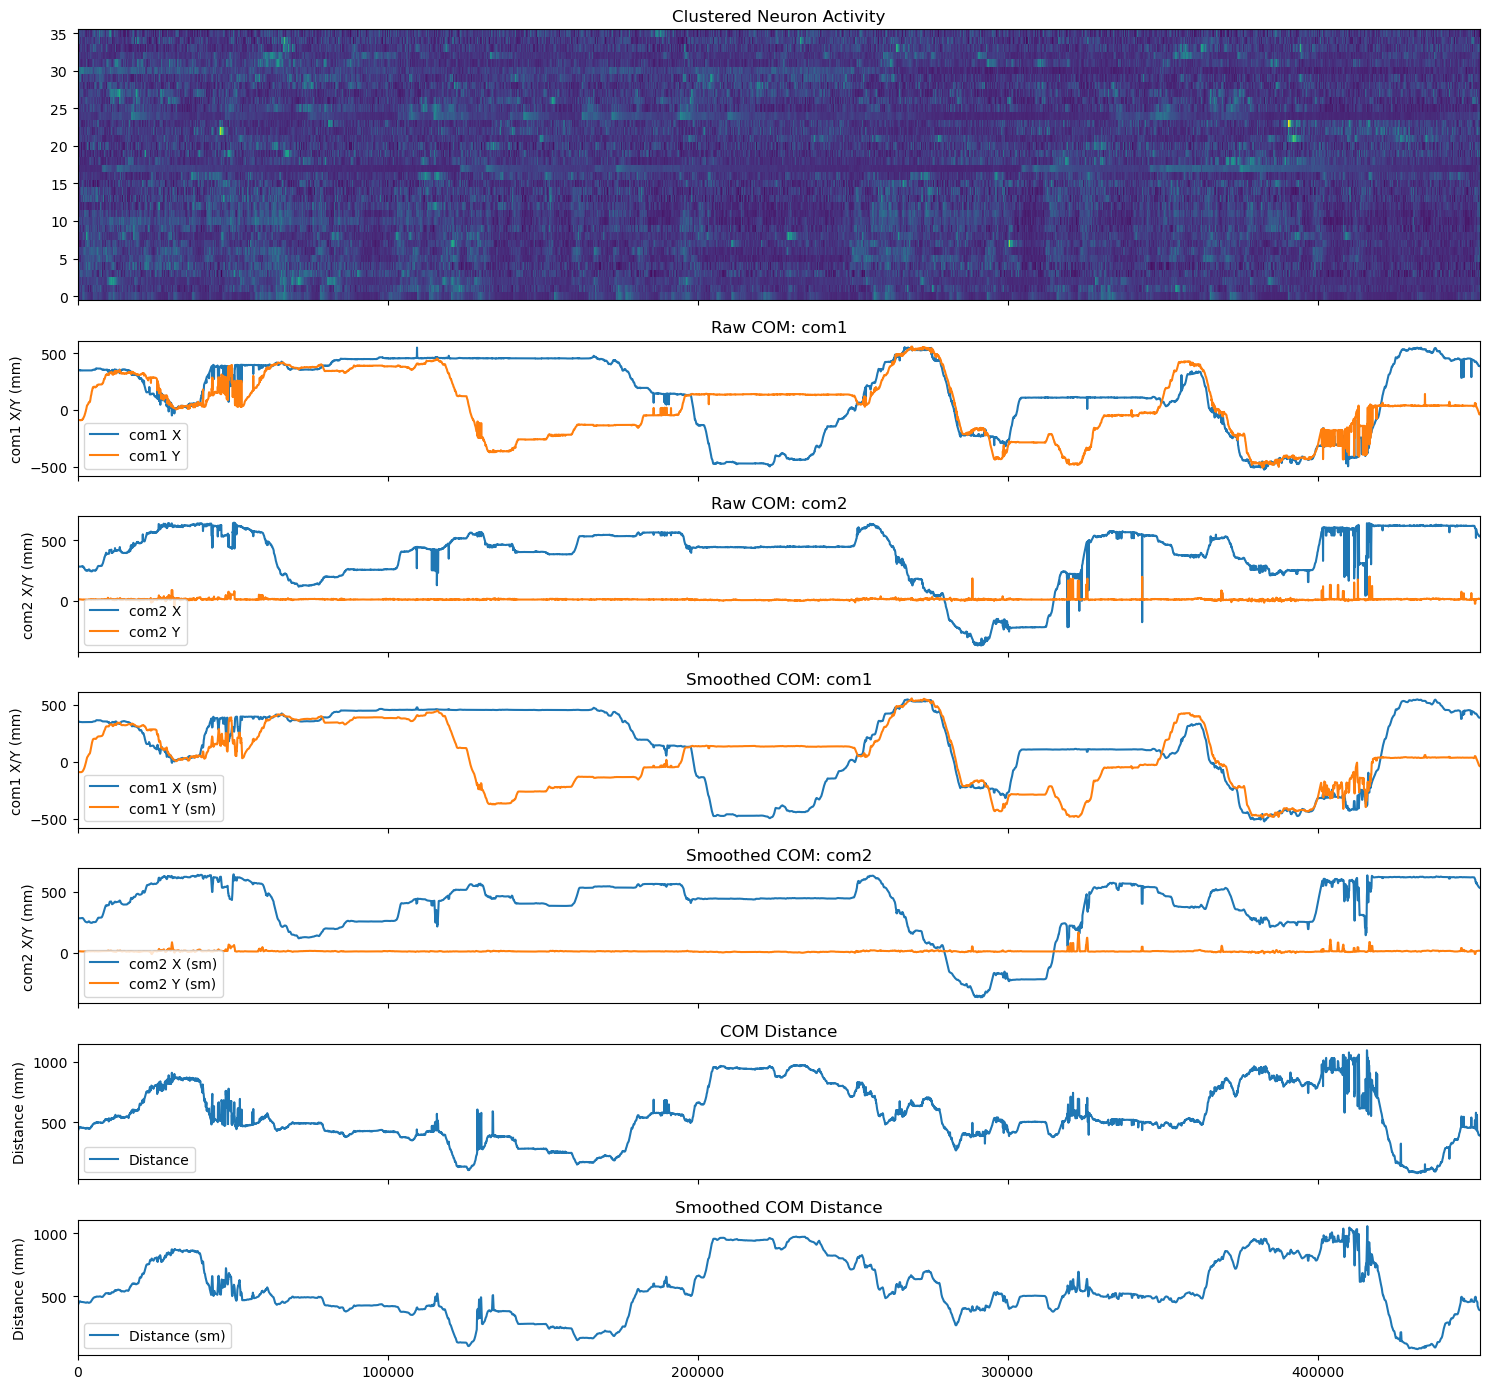

session plot saved at: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/MIR_Aligned


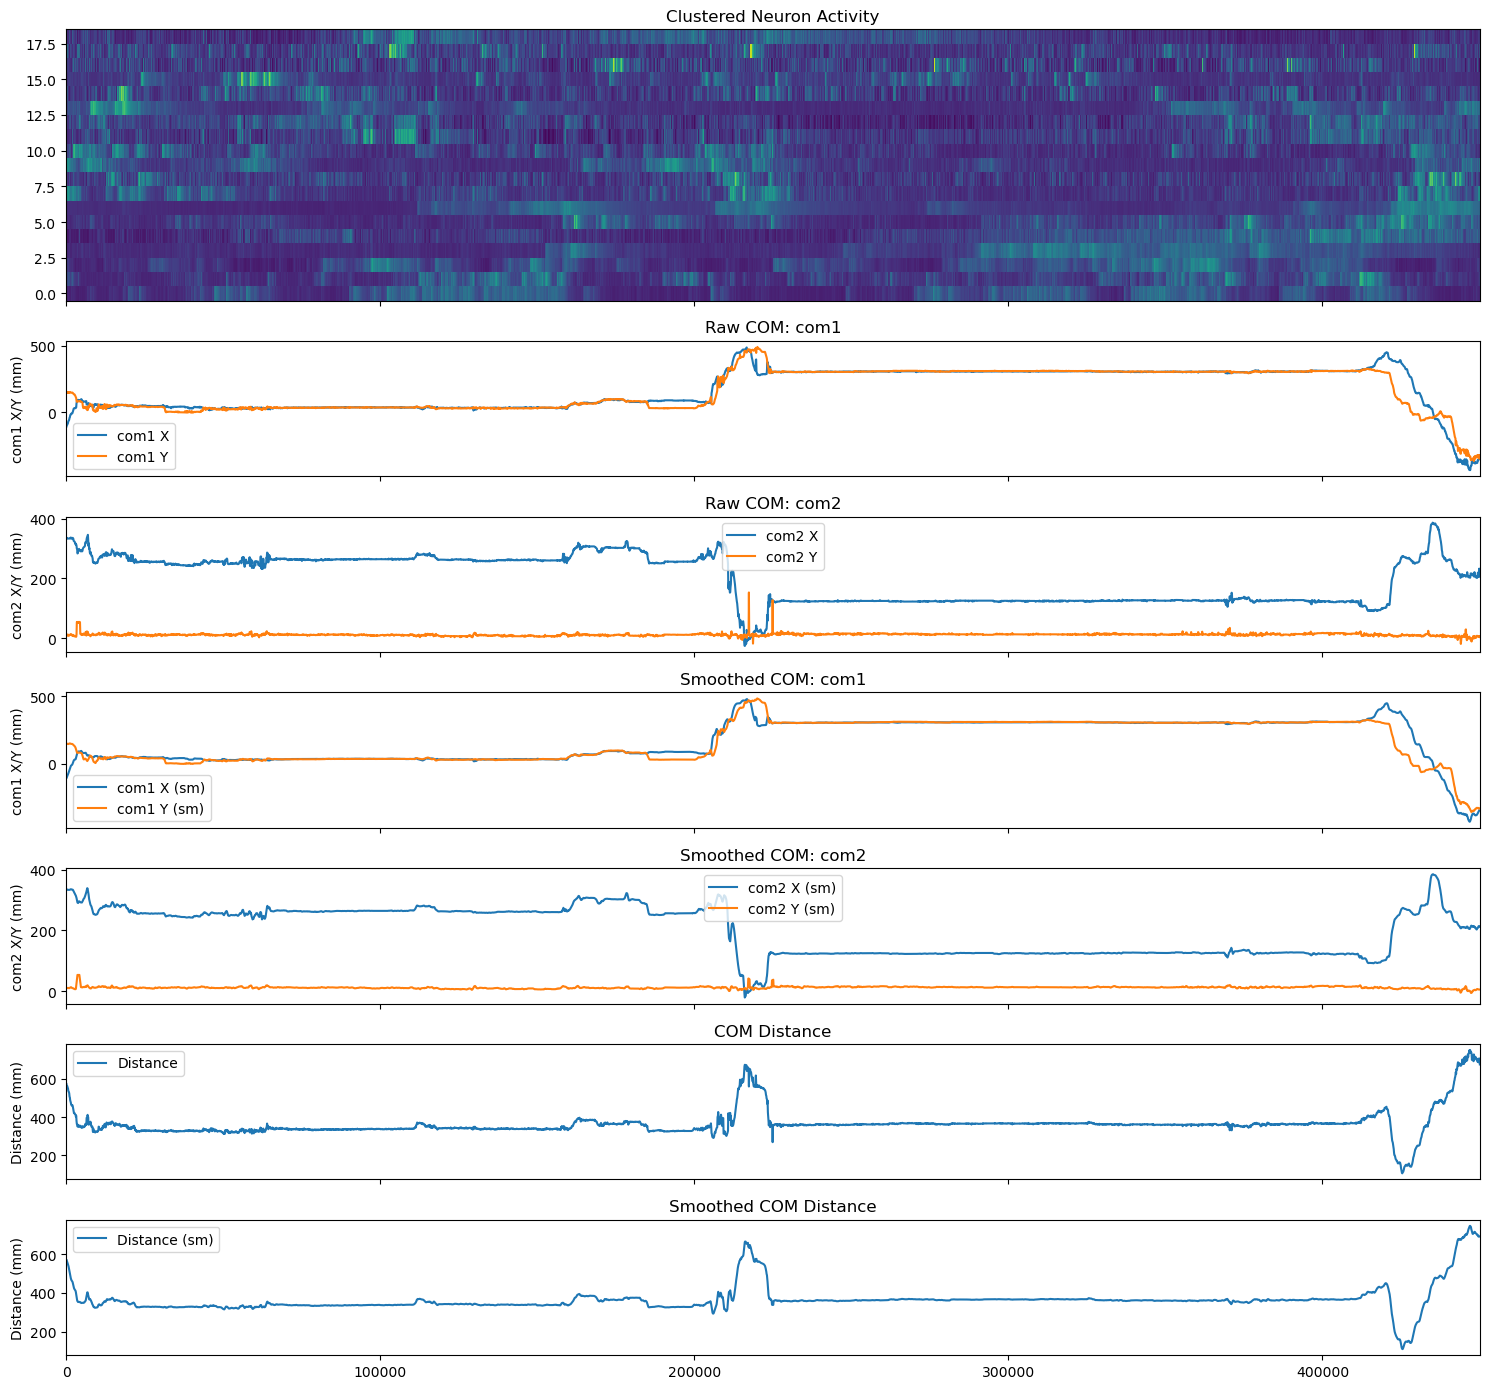

session plot saved at: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/MIR_Aligned


In [6]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')

    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df[neuron_cols].values.T
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 4. Plotting with separate & smoothed COM + distance
# ----------------------------------------------------------------------------
def plot_session_data(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )
    time = df_new['timestamp_ms_mini']

    # Identify com prefixes
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})

    # Compute smoothed COM (5-point moving average)
    com_cols = [f'{p}_{axis}' for p in com_prefixes for axis in ('x','y','z')]
    smoothed = df_new[com_cols].rolling(window=5, center=True).mean()

    # Compute distance between first two COMs
    if len(com_prefixes) >= 2:
        p1, p2 = com_prefixes[0], com_prefixes[1]
        dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
        dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
        dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
        dist = np.sqrt(dx**2 + dy**2 + dz**2)
        dist_sm = dist.rolling(window=5, center=True).mean()
    else:
        dist = pd.Series([])
        dist_sm = pd.Series([])

    # Setup figure: 1 heatmap + 2 raw COM + 2 smoothed COM + 2 distance = 7 rows
    fig = plt.figure(figsize=(15, 2 * 7))
    gs = fig.add_gridspec(nrows=7, ncols=1, height_ratios=[2] + [1]*6)

    # Heatmap
    ax0 = fig.add_subplot(gs[0, 0])
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data = neuron_norm[order, :]
        ax0.pcolormesh(time, np.arange(data.shape[0]), data, cmap='viridis', shading='auto')
        ax0.set_title('Clustered Neuron Activity')
    else:
        ax0.text(0.5, 0.5, 'No neuron data', transform=ax0.transAxes, ha='center')
        ax0.set_title('No Neuron Activity')
    ax0.tick_params(labelbottom=False)

    # Raw COM per animal
    for i, pref in enumerate(com_prefixes[:2], start=1):
        ax = fig.add_subplot(gs[i, 0], sharex=ax0)
        ax.plot(time, df_new[f'{pref}_x'], label=f'{pref} X')
        ax.plot(time, df_new[f'{pref}_y'], label=f'{pref} Y')
        ax.set_ylabel(f'{pref} X/Y (mm)')
        ax.set_title(f'Raw COM: {pref}')
        ax.legend()
        ax.tick_params(labelbottom=False)

    # Smoothed COM per animal
    for j, pref in enumerate(com_prefixes[:2], start=3):
        ax = fig.add_subplot(gs[j, 0], sharex=ax0)
        ax.plot(time, smoothed[f'{pref}_x'], label=f'{pref} X (sm)')
        ax.plot(time, smoothed[f'{pref}_y'], label=f'{pref} Y (sm)')
        ax.set_ylabel(f'{pref} X/Y (mm)')
        ax.set_title(f'Smoothed COM: {pref}')
        ax.legend()
        ax.tick_params(labelbottom=False)

    # Distance raw
    ax5 = fig.add_subplot(gs[5, 0], sharex=ax0)
    ax5.plot(time, dist, label='Distance')
    ax5.set_ylabel('Distance (mm)')
    ax5.set_title('COM Distance')
    ax5.legend()
    ax5.tick_params(labelbottom=False)

    # Distance smoothed
    ax6 = fig.add_subplot(gs[6, 0], sharex=ax0)
    ax6.plot(time, dist_sm, label='Distance (sm)')
    ax6.set_ylabel('Distance (mm)')
    ax6.set_title('Smoothed COM Distance')
    ax6.legend()

    plt.tight_layout()
    plt.show()
    # save figure into MIR_Aligned
    save_dir       = os.path.join(df_new['session_path'].iloc[0], 'MIR_Aligned')
    session_name   = os.path.basename(os.path.normpath(df_new['session_path'].iloc[0]))
    pred_name      = os.path.splitext(os.path.basename(df_new['file_path'].iloc[0]))[0]
    output_filename = f"session_plot_{session_name}_{pred_name}.png"
    fig.savefig(os.path.join(save_dir, output_filename), dpi=300)
    print(f"session plot saved at: {save_dir}")


# ------------------------------------------------------------------------------
# 5. Example Usage
# ------------------------------------------------------------------------------


# Plot with exclusion
# for path in session_paths:
#     df_s = load_session_data(path)
#     plot_session_data(df_s, exclude_dict=exclude_dict, apply_exclusion=True)

# Plot all neurons
for path in session_paths:
    df_s = load_session_data(path)
    plot_session_data(df_s, apply_exclusion=False)


plotting com_traga for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1


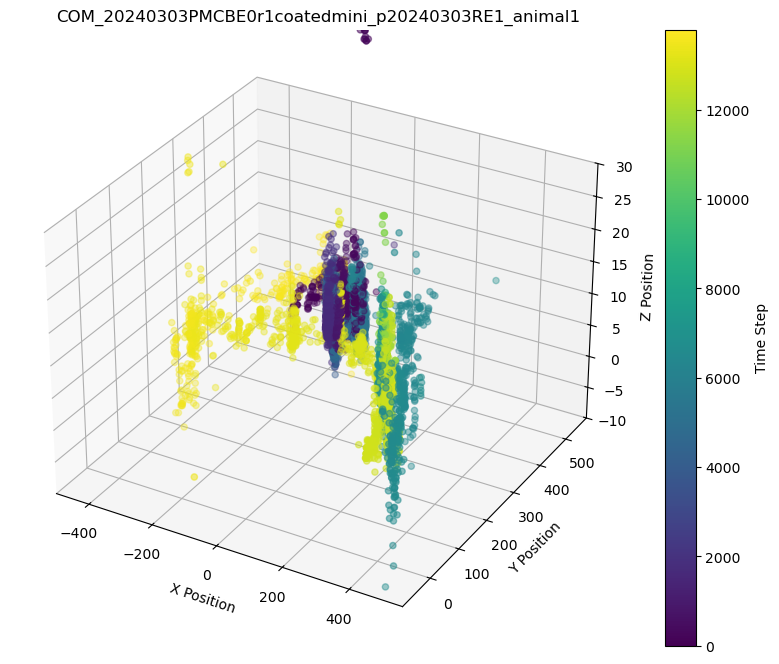

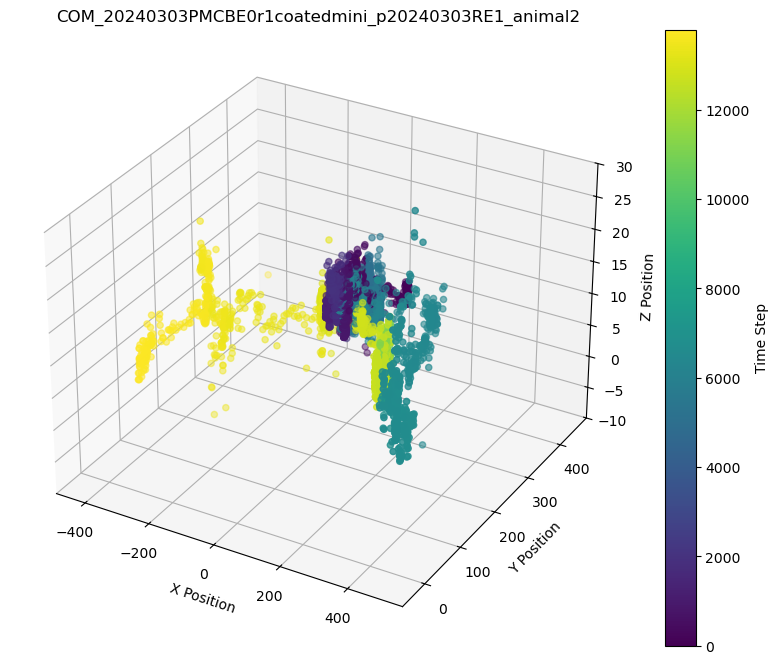

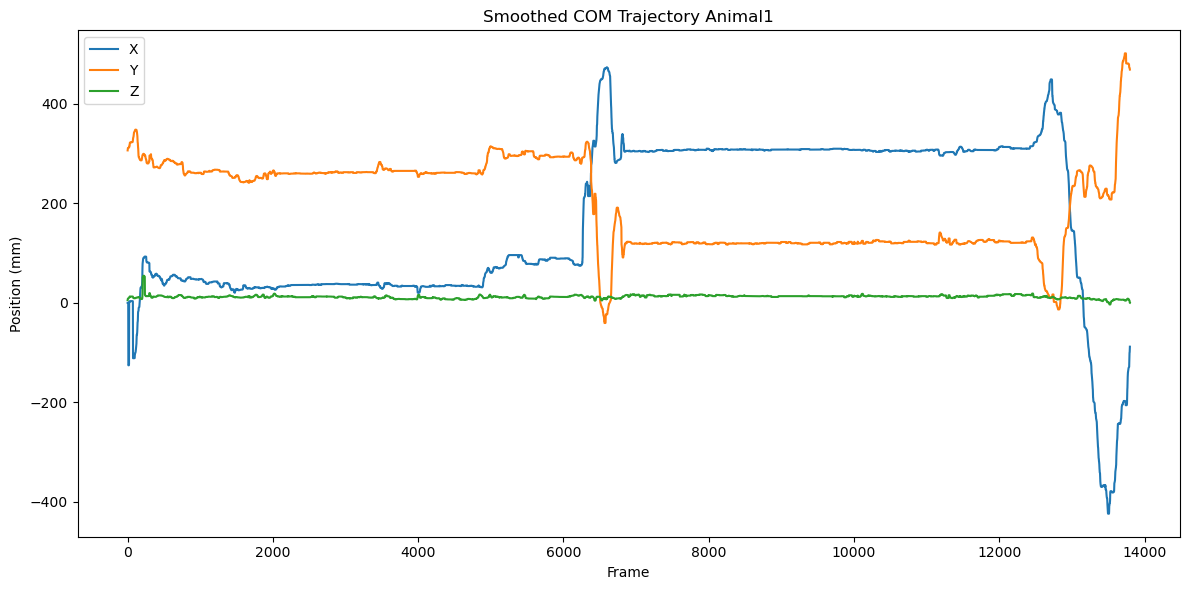

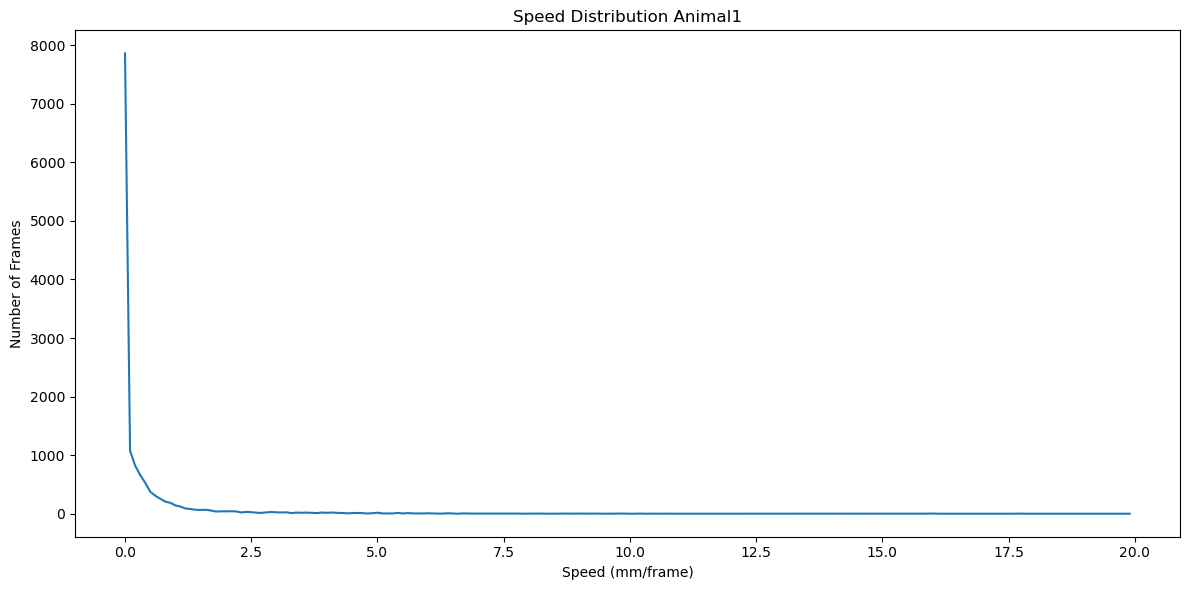

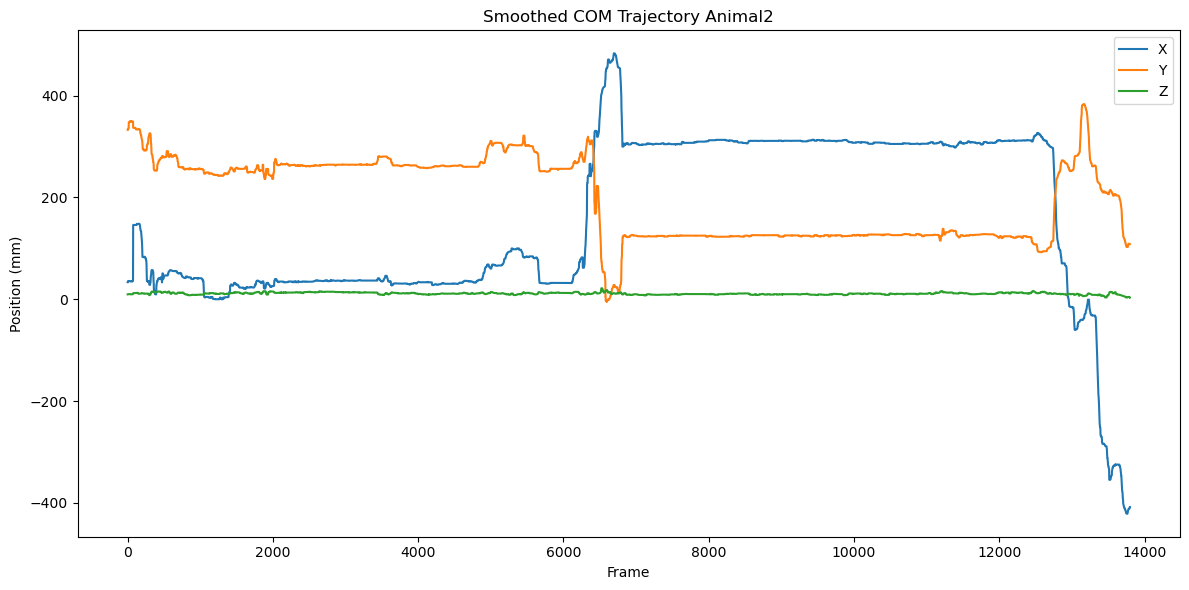

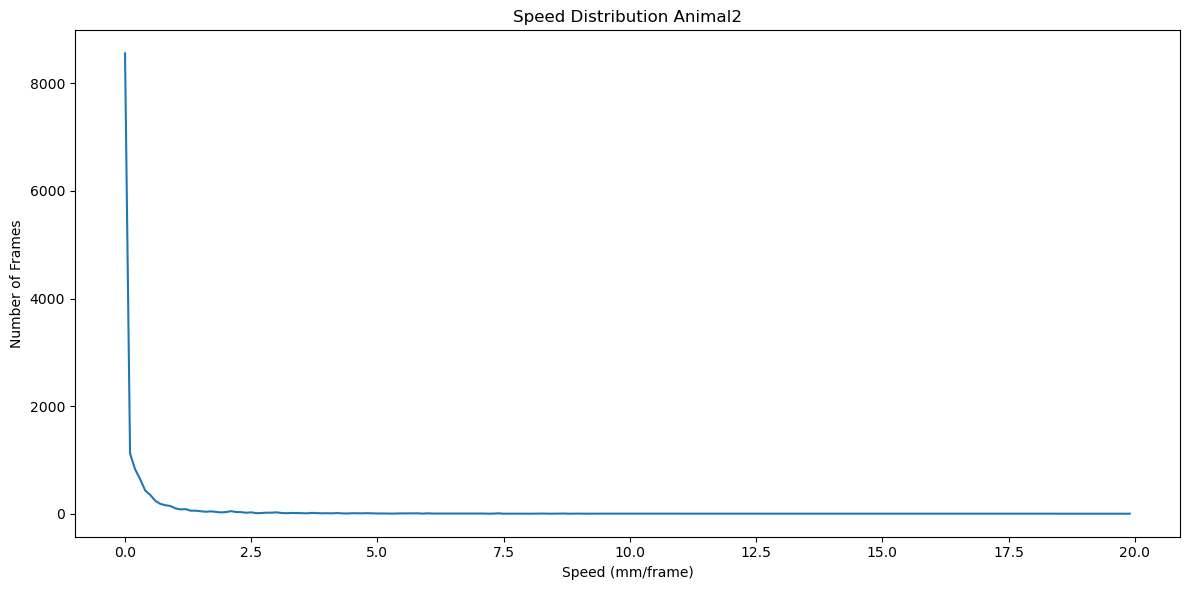

🚀 saved combined video at /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/COM/predict00/vis/vis_COM_20240303PMCBE0r1coatedmini_p20240303RE1_combined.mp4


In [1]:
# social com vis, for one rec

import sys
import os
sys.path.append(os.path.abspath('../..'))
# from utlis.vis_valid_utlis.com_trag_updated import plot_com_all
from utlis.vis_valid_utlis.scom_traga_utlis import plot_com_all_social


b = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
# "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_29/2social_mini_0605pmc_single_18_00"
# plot_com_all_social(b,perform_jump_indices=True, perform_video_generation=True) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False
plot_com_all_social(b,perform_generate_com_video=True)

In [4]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
# from utlis.vis_valid_utlis.com_trag_updated import plot_com_all
from utlis.vis_valid_utlis.scom_traga_utlis import standalone_generate_social_com_video



# b = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
b = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"


standalone_generate_social_com_video(b,start_frame=5000,
    num_frames=200)

plotting com_traga for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Saved combined COM video starting at frame 5000 → /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1/COM/predict00/vis/vis_2COM_20240303PMCBE0r1coatedmini_p20240303RE1_5000_200_combined_start5000.mp4


In [2]:
# for single com traces, not for social.
# from utlis.vis_valid_utlis.com_trace import plot_com_circle_for_path

# plot_com_circle_for_path(b)

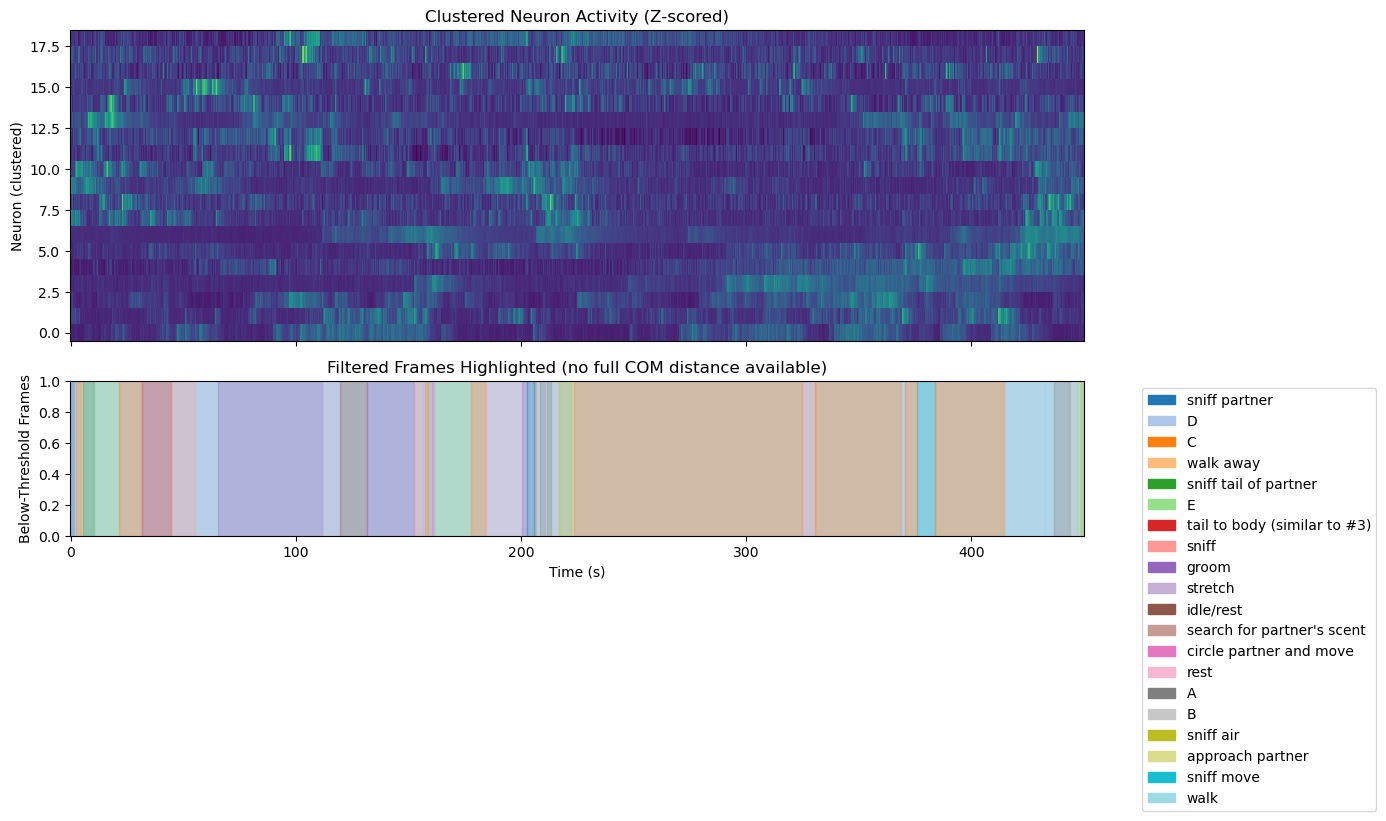

In [13]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    # 先重置索引，确保后续按行筛选时不会丢失列
    df_reset = df.reset_index(drop=True)

    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df_reset['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df_reset.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df_reset[neuron_cols].values.T
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)

    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(df, distance_threshold, exclude_dict=None,
                              manual_exclude_indices=None, apply_exclusion=True):
    neuron_norm, neuron_cols, df_reset = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    rec_path = df_reset['session_path'].iloc[0]
    aligned_dir = os.path.join(rec_path, 'MIR_Aligned')
    df_reset = df.reset_index()

    if 'camera_frame_sixcam' not in df_reset.columns or 'timestamp_ms_mini' not in df_reset.columns:
        raise KeyError("HDF5 数据中必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列")
    df_time_map = df_reset[['camera_frame_sixcam', 'timestamp_ms_mini']].drop_duplicates()

    com_csv = os.path.join(aligned_dir, 'com_distances.csv')
    has_full = os.path.exists(com_csv)

    if has_full:
        df_com = pd.read_csv(com_csv)
        if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
            raise KeyError("com_distances.csv 中必须包含 'frame' 和 'distance' 两列")
        df_com_merged = pd.merge(
            df_com,
            df_time_map,
            left_on='frame',
            right_on='camera_frame_sixcam',
            how='inner'
        )
        times_all_ms = df_com_merged['timestamp_ms_mini'].values
        distances_raw = df_com_merged['distance'].values
        frames_all = df_com_merged['frame'].values.astype(int)
        time_all_s = times_all_ms / 1000.0
        below_thresh = (distances_raw <= distance_threshold)
        filtered_frames = frames_all[below_thresh]
    else:
        filtered_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
        if not os.path.exists(filtered_csv):
            raise FileNotFoundError(
                f"Cannot find com_distances.csv or com_distances_filtered.csv in {aligned_dir}"
            )
        df_filtered = pd.read_csv(filtered_csv)
        frame_col = df_filtered.columns[0]
        filtered_frames = df_filtered[frame_col].astype(int).values
        time_all_s = np.array([])
        distances_raw = np.array([])
        below_thresh = np.array([])

    mask = df_reset['camera_frame_sixcam'].isin(filtered_frames)
    times_mask_ms = df_reset['timestamp_ms_mini'].values
    times_mask_s = times_mask_ms / 1000.0

    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2, ncols=1, figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 热图
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        ax_heatmap.pcolormesh(
            times_mask_s if len(times_mask_s)>0 else np.arange(data_ordered.shape[1]),
            np.arange(data_ordered.shape[0]),
            data_ordered,
            cmap='viridis',
            shading='auto'
        )
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes, ha='center'
        )
    ax_heatmap.set_ylabel('Neuron (clustered)')
    ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # 距离图
    if has_full:
        ax_dist.plot(time_all_s, distances_raw, linewidth=1, label='COM Distance')
        ax_dist.fill_between(
            time_all_s, distances_raw, distance_threshold,
            where=(distances_raw <= distance_threshold),
            alpha=0.3, label='Below threshold'
        )
        ax_dist.axhline(distance_threshold, linestyle='--', linewidth=0.8)
        ax_dist.set_ylabel('Distance (mm)')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(f'COM Distance (threshold = {distance_threshold:.3f})')
        ax_dist.legend(loc='upper right')
    else:
        ax_dist.set_ylabel('Below-Threshold Frames')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title('Filtered Frames Highlighted (no full COM distance available)')
        if len(times_mask_s) > 0:
            ax_dist.fill_between(
                times_mask_s, 0, 1,
                where=mask,
                alpha=0.3,
                transform=ax_dist.get_xaxis_transform()
            )
        ax_dist.set_ylim(0, 1)

    # ----------------------------------------------------------------------------
    # 5. Load behavior segments and overlay (fixed NaN handling)
    # ----------------------------------------------------------------------------
    segments_csv = '/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv'
    if os.path.exists(segments_csv):
        df_seg = pd.read_csv(segments_csv)
        # 合并 behavior 与 category
        df_seg['label'] = df_seg['behavior'].fillna(df_seg['category'])
        # 准备好可用的帧范围
        valid_frames = df_time_map['camera_frame_sixcam']
        min_f, max_f = valid_frames.min(), valid_frames.max()
        # 填充缺失的 start/end frames，再转换为 int
        df_seg['start_frame'] = df_seg['start_frame'].fillna(min_f).astype(int)
        df_seg['end_frame']   = df_seg['end_frame'].fillna(max_f).astype(int)

        labels = df_seg['label'].unique()
        cmap = plt.get_cmap('tab20')
        color_dict = {label: cmap(i) for i, label in enumerate(labels)}
        time_map = (df_time_map
                    .set_index('camera_frame_sixcam')['timestamp_ms_mini']
                    / 1000.0)

        for _, row in df_seg.iterrows():
            f0, f1 = row['start_frame'], row['end_frame']
            if f0 not in time_map.index:
                f0 = valid_frames[valid_frames >= f0].min()
            if f1 not in time_map.index:
                f1 = valid_frames[valid_frames <= f1].max()
            t0, t1 = time_map.loc[f0], time_map.loc[f1]
            ax_dist.axvspan(t0, t1, color=color_dict[row['label']], alpha=0.3)

        patches = [mpatches.Patch(color=color_dict[l], label=l) for l in labels]
        ax_dist.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show(fig)

# ----------------------------------------------------------------------------
# 6. Example usage
# ----------------------------------------------------------------------------
session_paths = [
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",
]
threshold_value = 250

for path in session_paths:
    try:
        df_session = load_session_data(path)
        plot_cluster_and_distance(
            df_session,
            distance_threshold=threshold_value,
            exclude_dict=exclude_dict,
            apply_exclusion=True
        )
    except Exception as e:
        print(f"Failed for session {path}: {e}")


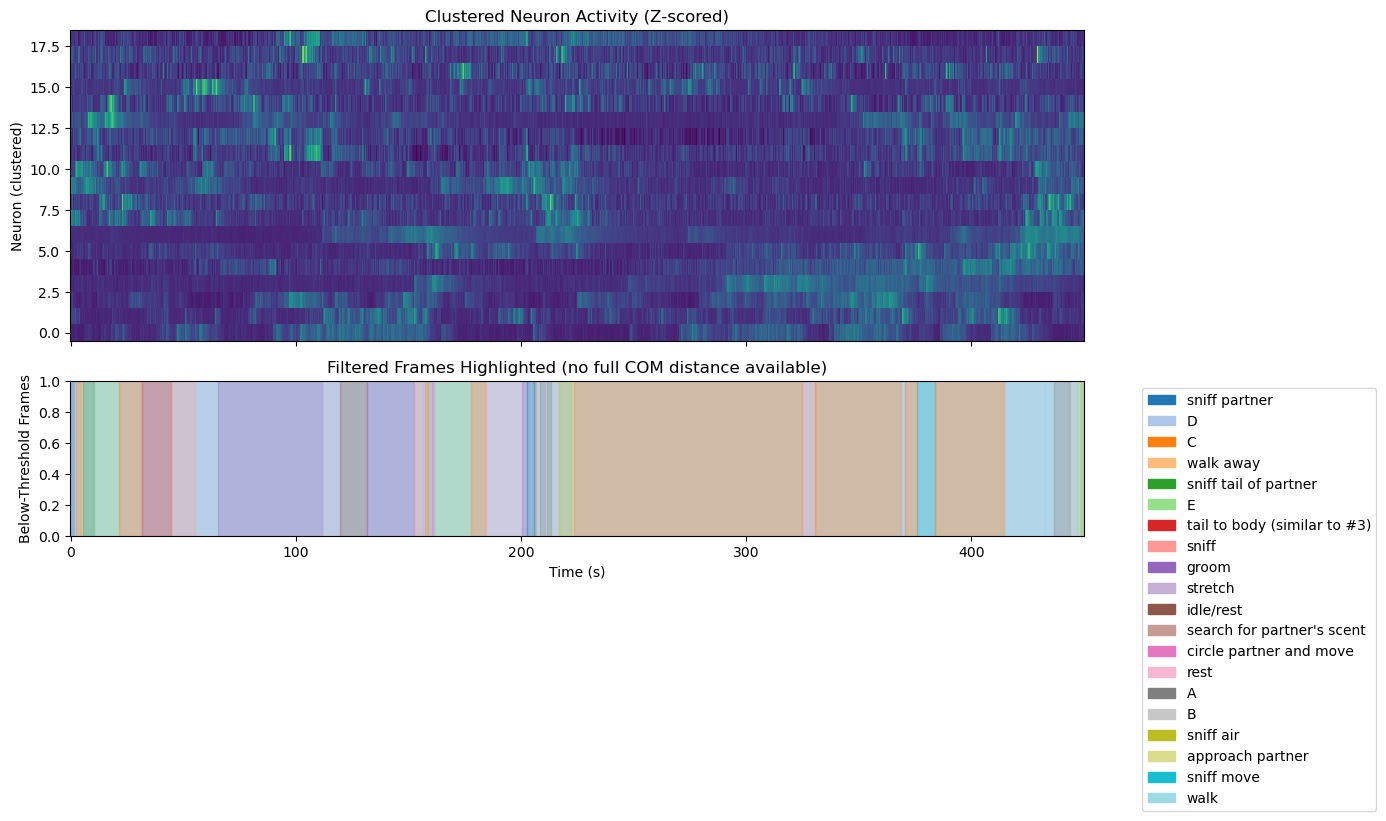

In [15]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Load exclusion mapping
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_dict = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 2. Load session HDF5
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    hdf5_file_path = h5_files[0]

    df = pd.read_hdf(hdf5_file_path, key='df')
    # 先重置索引，确保后续按行筛选时不会丢失列
    norm_path = os.path.normpath(rec_path)
    df['session_id']      = os.path.basename(norm_path)
    df['recording_date']  = os.path.basename(os.path.dirname(norm_path))
    df['experiment']      = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']    = rec_path
    df['file_path']       = hdf5_file_path
    return df

# ----------------------------------------------------------------------------
# 3. Process neuron activity
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict=None, manual_exclude_indices=None, apply_exclusion=True):
    # 先重置索引，确保后续按行筛选时不会丢失列
    df_reset = df.reset_index(drop=True)

    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        elif exclude_dict is not None:
            excluded = get_excluded_neurons_for_session(df_reset['session_path'].iloc[0], exclude_dict)
        else:
            excluded = []
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df_reset.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    activity = df_reset[neuron_cols].values.T
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5)
    keep = variances > thresh
    filtered = activity[keep, :]
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1)

    return normalized, filtered_cols, df_reset

# ----------------------------------------------------------------------------
# 4. Main plotting routine
# ----------------------------------------------------------------------------
def plot_cluster_and_distance(df, distance_threshold, exclude_dict=None,
                              manual_exclude_indices=None, apply_exclusion=True):
    neuron_norm, neuron_cols, df_reset = process_neuron_activity(
        df, exclude_dict, manual_exclude_indices, apply_exclusion
    )

    rec_path = df_reset['session_path'].iloc[0]
    aligned_dir = os.path.join(rec_path, 'MIR_Aligned')
    df_reset = df.reset_index()

    if 'camera_frame_sixcam' not in df_reset.columns or 'timestamp_ms_mini' not in df_reset.columns:
        raise KeyError("HDF5 数据中必须包含 'camera_frame_sixcam' 和 'timestamp_ms_mini' 两列")
    df_time_map = df_reset[['camera_frame_sixcam', 'timestamp_ms_mini']].drop_duplicates()

    # 原始 COM distance 和 filtered CSV 路径
    com_full_csv     = os.path.join(aligned_dir, 'com_distances.csv')
    com_filtered_csv = os.path.join(aligned_dir, 'com_distances_filtered.csv')
    has_full = os.path.exists(com_full_csv)

    if has_full:
        df_com = pd.read_csv(com_full_csv)
        if 'frame' not in df_com.columns or 'distance' not in df_com.columns:
            raise KeyError("com_distances.csv 中必须包含 'frame' 和 'distance' 两列")
        df_com_merged = pd.merge(
            df_com,
            df_time_map,
            left_on='frame',
            right_on='camera_frame_sixcam',
            how='inner'
        )
        times_all_ms   = df_com_merged['timestamp_ms_mini'].values
        distances_raw  = df_com_merged['distance'].values
        frames_all     = df_com_merged['frame'].values.astype(int)
        time_all_s     = times_all_ms / 1000.0
        below_thresh   = (distances_raw <= distance_threshold)
        filtered_frames = frames_all[below_thresh]
    else:
        if not os.path.exists(com_filtered_csv):
            raise FileNotFoundError(
                f"Cannot find com_distances.csv or com_distances_filtered.csv in {aligned_dir}"
            )
        df_filtered = pd.read_csv(com_filtered_csv)
        frame_col = df_filtered.columns[0]
        filtered_frames = df_filtered[frame_col].astype(int).values
        time_all_s    = np.array([])
        distances_raw = np.array([])
        below_thresh  = np.array([])

    mask = df_reset['camera_frame_sixcam'].isin(filtered_frames)
    times_mask_ms = df_reset['timestamp_ms_mini'].values
    times_mask_s  = times_mask_ms / 1000.0

    fig, (ax_heatmap, ax_dist) = plt.subplots(
        nrows=2, ncols=1, figsize=(14, 8),
        gridspec_kw={'height_ratios': [2, 1]},
        sharex=True
    )

    # 热图
    if neuron_norm.size:
        Z = linkage(neuron_norm, method='ward')
        order = leaves_list(Z)
        data_ordered = neuron_norm[order, :]
        ax_heatmap.pcolormesh(
            times_mask_s if len(times_mask_s)>0 else np.arange(data_ordered.shape[1]),
            np.arange(data_ordered.shape[0]),
            data_ordered,
            cmap='viridis',
            shading='auto'
        )
    else:
        ax_heatmap.text(
            0.5, 0.5, 'No neuron data after filtering',
            transform=ax_heatmap.transAxes, ha='center'
        )
    ax_heatmap.set_ylabel('Neuron (clustered)')
    ax_heatmap.set_title('Clustered Neuron Activity (Z-scored)')
    ax_heatmap.tick_params(labelbottom=False)

    # COM distance 曲线 + 阈值高亮
    if has_full:
        ax_dist.plot(time_all_s, distances_raw, linewidth=1, label='COM Distance')
        ax_dist.fill_between(
            time_all_s, distances_raw, distance_threshold,
            where=(distances_raw <= distance_threshold),
            alpha=0.3, label='Below threshold'
        )
        ax_dist.axhline(distance_threshold, linestyle='--', linewidth=0.8)
        ax_dist.set_ylabel('Distance (mm)')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title(f'COM Distance (threshold = {distance_threshold:.3f})')
        ax_dist.legend(loc='upper right')
    else:
        ax_dist.set_ylabel('Below-Threshold Frames')
        ax_dist.set_xlabel('Time (s)')
        ax_dist.set_title('Filtered Frames Highlighted (no full COM distance available)')
        if len(times_mask_s) > 0:
            ax_dist.fill_between(
                times_mask_s, 0, 1,
                where=mask,
                alpha=0.3,
                transform=ax_dist.get_xaxis_transform()
            )
        ax_dist.set_ylim(0, 1)

    # ----------------------------------------------------------------------------
    # 5. Load behavior segments and overlay (handling NaN)
    # ----------------------------------------------------------------------------
    segments_csv = '/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv'
    if os.path.exists(segments_csv):
        df_seg = pd.read_csv(segments_csv)
        df_seg['label'] = df_seg['behavior'].fillna(df_seg['category'])

        valid_frames = df_time_map['camera_frame_sixcam']
        min_f, max_f = valid_frames.min(), valid_frames.max()
        df_seg['start_frame'] = df_seg['start_frame'].fillna(min_f).astype(int)
        df_seg['end_frame']   = df_seg['end_frame'].fillna(max_f).astype(int)

        labels = df_seg['label'].unique()
        cmap = plt.get_cmap('tab20')
        color_dict = {label: cmap(i) for i, label in enumerate(labels)}
        time_map = (df_time_map
                    .set_index('camera_frame_sixcam')['timestamp_ms_mini']
                    / 1000.0)

        for _, row in df_seg.iterrows():
            f0, f1 = row['start_frame'], row['end_frame']
            if f0 not in time_map.index:
                f0 = valid_frames[valid_frames >= f0].min()
            if f1 not in time_map.index:
                f1 = valid_frames[valid_frames <= f1].max()
            t0, t1 = time_map.loc[f0], time_map.loc[f1]
            ax_dist.axvspan(t0, t1, color=color_dict[row['label']], alpha=0.3)

        patches = [mpatches.Patch(color=color_dict[l], label=l) for l in labels]
        ax_dist.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show(fig)

# ----------------------------------------------------------------------------
# 6. Example usage
# ----------------------------------------------------------------------------
session_paths = [
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",
]
threshold_value = 250

for path in session_paths:
    try:
        df_session = load_session_data(path)
        plot_cluster_and_distance(
            df_session,
            distance_threshold=threshold_value,
            exclude_dict=exclude_dict,
            apply_exclusion=True
        )
    except Exception as e:
        print(f"Failed for session {path}: {e}")


In [27]:
import os
import glob
import json
import numpy as np
import pandas as pd

def load_session_data(rec_path):
    """
    Load the aligned HDF5 for one session and add metadata columns.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No HDF5 found in {h5_dir}")
    h5_path = h5_files[0]

    df = pd.read_hdf(h5_path, key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    return df.reset_index(drop=True)

def load_segments(csv_path):
    """
    Read the Continuous_Labeled_Segments.csv and merge behavior/category into a single label.
    Returns start_frame and end_frame as floats (NaN if missing), plus 'label'.
    """
    df = pd.read_csv(csv_path)
    df['label'] = df['behavior'].fillna(df['category'])
    # ensure start/end are numeric
    df['start_frame'] = pd.to_numeric(df['start_frame'], errors='coerce')
    df['end_frame']   = pd.to_numeric(df['end_frame'],   errors='coerce')
    return df[['start_frame', 'end_frame', 'label']]

def compute_95th_by_category(df, segments):
    """
    For each category label, collect all timepoints whose camera_frame_sixcam
    falls within any of that label's segments (handling NaN start/end by
    using the session's min/max frame). Compute the 95th percentile of each
    dF/F column within that label.
    Returns a DataFrame: index=neuron cols, columns=labels.
    """
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi')]
    labels = segments['label'].unique()
    result = pd.DataFrame(index=neuron_cols, columns=labels, dtype=float)

    valid_frames = df['camera_frame_sixcam'].unique()
    min_f, max_f = valid_frames.min(), valid_frames.max()

    for lbl in labels:
        segs = segments[segments['label'] == lbl]
        mask = pd.Series(False, index=df.index)
        for _, seg in segs.iterrows():
            start = seg['start_frame']
            end   = seg['end_frame']
            # handle NaN
            if np.isnan(start):
                start = min_f
            if np.isnan(end):
                end = max_f
            # cast to ints within valid range
            start_i = int(max(min_f, start))
            end_i   = int(min(max_f, end))
            mask |= (df['camera_frame_sixcam'] >= start_i) & (df['camera_frame_sixcam'] <= end_i)
        if mask.any():
            subset = df.loc[mask, neuron_cols]
            result[lbl] = subset.quantile(0.95)
        else:
            result[lbl] = np.nan

    return result

def main():
    session_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
    segments_csv = "/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv"

    df = load_session_data(session_path)
    segments = load_segments(segments_csv)

    percentiles = compute_95th_by_category(df, segments)

    out_csv = os.path.join(session_path, "neuron_95th_by_category_merged.csv")
    percentiles.to_csv(out_csv)
    print(f"Saved 95th-percentile table to {out_csv}")
    print(percentiles)

if __name__ == "__main__":
    main()


Saved 95th-percentile table to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category_merged.csv
            sniff partner         D         C  walk away  \
dF_F_roi0        0.758818  1.157367  1.023643   1.142635   
dF_F_roi1        2.279846  4.367385  6.170224   0.512010   
dF_F_roi2        1.897268  1.968905  2.170838   0.863502   
dF_F_roi3        1.944962  1.977113  1.764695   2.537832   
dF_F_roi4        3.643159  2.017019  3.672660   1.689487   
dF_F_roi5        1.131791  1.452788  2.085334   1.403524   
dF_F_roi6        1.098006  1.574667  2.527356   1.146940   
dF_F_roi7        1.199023  1.991337  1.747576   1.205980   
dF_F_roi8        2.465801  3.938360  3.830902   0.562497   
dF_F_roi9        0.584156  2.182721  2.361120   2.458089   
dF_F_roi10       0.586049  2.526335  2.149895   2.131408   
dF_F_roi11       0.885866  2.016747  1.589795   1.977264   
dF_F_roi12       2.485979  2.257246  1.857567   0.377744   
dF_F_ro

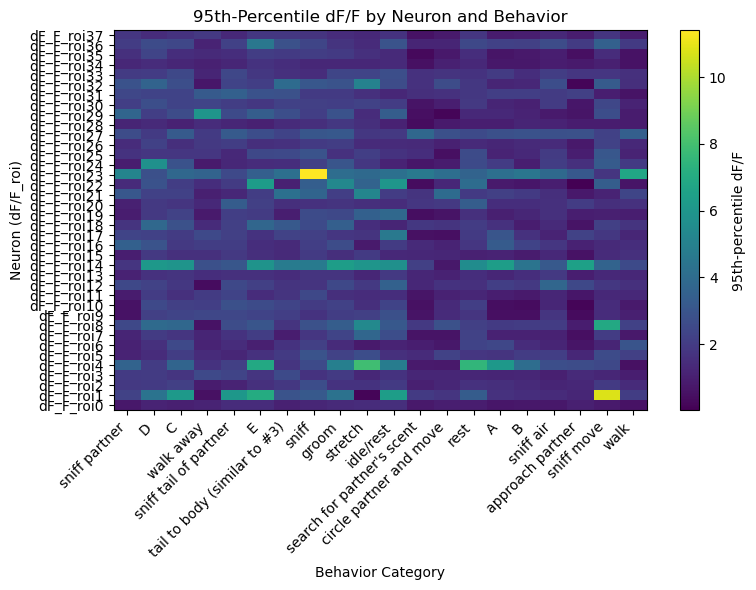

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_95th_heatmap(csv_path):
    # Load the table: index = neuron cols, columns = labels
    df = pd.read_csv(csv_path, index_col=0)
    
    # Extract values
    values = df.values  # shape (n_neurons, n_categories)
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, max(6, len(df) * 0.1)))
    im = ax.imshow(values, aspect='auto', origin='lower')
    
    # Axis ticks
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index)
    
    ax.set_xlabel('Behavior Category')
    ax.set_ylabel('Neuron (dF/F_roi)')
    ax.set_title('95th-Percentile dF/F by Neuron and Behavior')
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('95th-percentile dF/F')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category.csv"
    plot_95th_heatmap(csv_path)


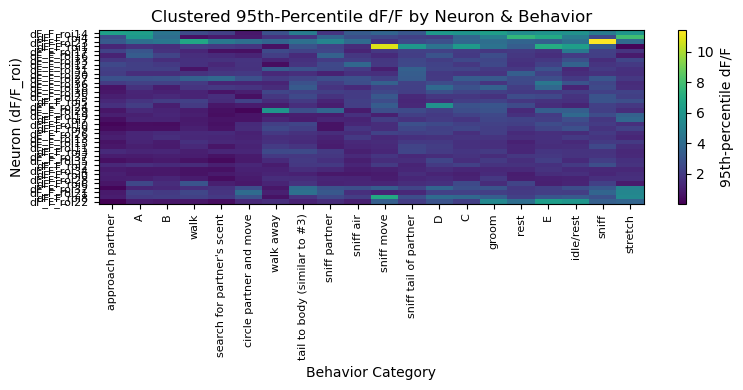

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_clustered_95th(csv_path):
    # 1. load
    df = pd.read_csv(csv_path, index_col=0)
    data = df.values  # shape: (n_neurons, n_behaviors)

    # 2. hierarchical clustering on rows and columns
    row_linkage = linkage(data, method='ward')
    col_linkage = linkage(data.T, method='ward')
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # 3. reorder
    ordered_data    = data[row_order][:, col_order]
    ordered_neurons = df.index[row_order]
    ordered_labels  = df.columns[col_order]

    # 4. plot
    fig, ax = plt.subplots(
        figsize=(8, max(4, len(ordered_neurons)*0.1))
    )
    mesh = ax.pcolormesh(
        ordered_data,
        cmap='viridis',
        shading='auto'
    )

    # ticks in the center of each cell
    ax.set_yticks(np.arange(len(ordered_neurons)) + 0.5)
    ax.set_yticklabels(ordered_neurons, fontsize=8)

    ax.set_xticks(np.arange(len(ordered_labels)) + 0.5)
    ax.set_xticklabels(ordered_labels, rotation=90, fontsize=8)

    ax.set_xlabel('Behavior Category')
    ax.set_ylabel('Neuron (dF/F_roi)')
    ax.set_title('Clustered 95th-Percentile dF/F by Neuron & Behavior')

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('95th-percentile dF/F')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category.csv"
    plot_clustered_95th(csv_path)


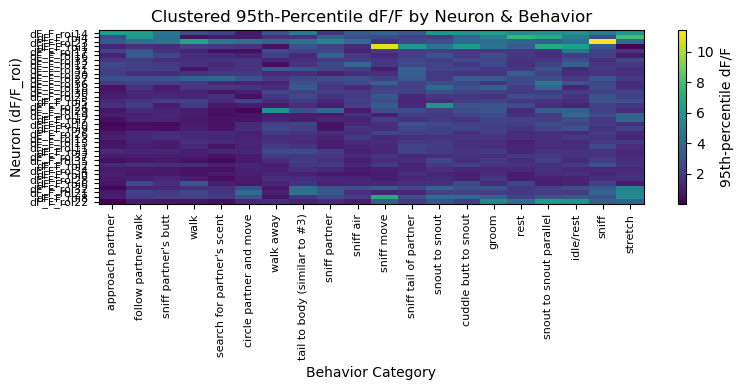

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_clustered_95th_with_labels(csv_path):
    # 1. load
    df = pd.read_csv(csv_path, index_col=0)
    
    # 2. rename A–E to your descriptive labels
    label_map = {
        'A': 'follow partner walk',
        'B': "sniff partner's butt",
        'C': 'cuddle butt to snout',
        'D': 'snout to snout',
        'E': 'snout to snout parallel'
    }
    df.rename(columns=label_map, inplace=True)

    data = df.values  # shape: (n_neurons, n_behaviors)

    # 3. hierarchical clustering on rows and columns
    row_linkage = linkage(data, method='ward')
    col_linkage = linkage(data.T, method='ward')
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # 4. reorder
    ordered_data    = data[row_order][:, col_order]
    ordered_neurons = df.index[row_order]
    ordered_labels  = df.columns[col_order]

    # 5. plot
    fig, ax = plt.subplots(
        figsize=(8, max(4, len(ordered_neurons)*0.1))
    )
    mesh = ax.pcolormesh(
        ordered_data,
        cmap='viridis',
        shading='auto'
    )

    # ticks in center of each cell
    ax.set_yticks(np.arange(len(ordered_neurons)) + 0.5)
    ax.set_yticklabels(ordered_neurons, fontsize=8)

    ax.set_xticks(np.arange(len(ordered_labels)) + 0.5)
    ax.set_xticklabels(ordered_labels, rotation=90, fontsize=8)

    ax.set_xlabel('Behavior Category')
    ax.set_ylabel('Neuron (dF/F_roi)')
    ax.set_title('Clustered 95th-Percentile dF/F by Neuron & Behavior')

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('95th-percentile dF/F')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category.csv"
    plot_clustered_95th_with_labels(csv_path)


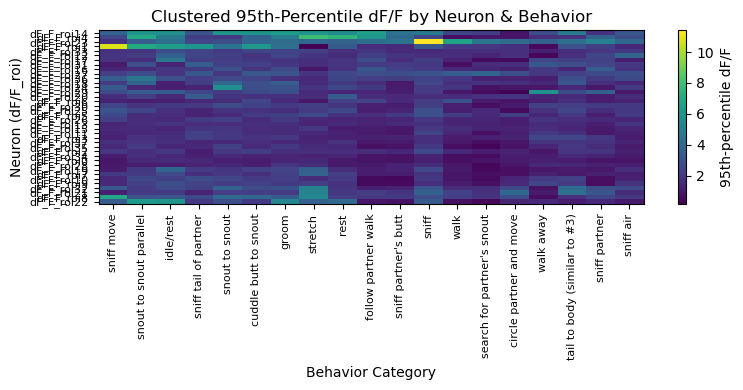

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_clustered_95th_with_labels(csv_path):
    # 1. load
    df = pd.read_csv(csv_path, index_col=0)
    
    # 2. rename A–E to your descriptive labels
    label_map = {
        'A': 'follow partner walk',
        'B': "sniff partner's butt",
        'C': 'cuddle butt to snout',
        'D': 'snout to snout',
        'E': 'snout to snout parallel'
    }
    df.rename(columns=label_map, inplace=True)

    data = df.values  # shape: (n_neurons, n_behaviors)

    # 3. hierarchical clustering on rows and columns
    row_linkage = linkage(data, method='ward')
    col_linkage = linkage(data.T, method='ward')
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)

    # 4. reorder
    ordered_data    = data[row_order][:, col_order]
    ordered_neurons = df.index[row_order]
    ordered_labels  = df.columns[col_order]

    # 5. plot
    fig, ax = plt.subplots(
        figsize=(8, max(4, len(ordered_neurons)*0.1))
    )
    mesh = ax.pcolormesh(
        ordered_data,
        cmap='viridis',
        shading='auto'
    )

    # ticks in center of each cell
    ax.set_yticks(np.arange(len(ordered_neurons)) + 0.5)
    ax.set_yticklabels(ordered_neurons, fontsize=8)

    ax.set_xticks(np.arange(len(ordered_labels)) + 0.5)
    ax.set_xticklabels(ordered_labels, rotation=90, fontsize=8)

    ax.set_xlabel('Behavior Category')
    ax.set_ylabel('Neuron (dF/F_roi)')
    ax.set_title('Clustered 95th-Percentile dF/F by Neuron & Behavior')

    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('95th-percentile dF/F')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category_merged.csv"
    plot_clustered_95th_with_labels(csv_path)


In [30]:
import os
import glob
import json
import numpy as np
import pandas as pd

def load_session_data(rec_path):
    """
    Load the aligned HDF5 for one session and add metadata columns.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No HDF5 found in {h5_dir}")
    h5_path = h5_files[0]

    df = pd.read_hdf(h5_path, key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    return df.reset_index(drop=True)

def compute_95th_social_vs_non(rec_path, segments_csv):
    # 1. load your session data
    df = load_session_data(rec_path)

    # 2. load the labeled segments CSV (with 'sociality' column)
    seg = pd.read_csv(segments_csv)

    # 3. get the full range of valid frames
    min_f = int(df['camera_frame_sixcam'].min())
    max_f = int(df['camera_frame_sixcam'].max())

    # 4. ensure start/end are numeric, fill NaN with min/max, cast to int
    seg['start_frame'] = pd.to_numeric(seg['start_frame'], errors='coerce').fillna(min_f).astype(int)
    seg['end_frame']   = pd.to_numeric(seg['end_frame'],   errors='coerce').fillna(max_f).astype(int)

    # 5. list of your neuron columns
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi')]

    # 6. build masks for social vs non_social
    def make_mask(group):
        m = pd.Series(False, index=df.index)
        for _, row in seg[seg['sociality'] == group].iterrows():
            m |= ((df['camera_frame_sixcam'] >= row['start_frame']) &
                  (df['camera_frame_sixcam'] <= row['end_frame']))
        return m

    mask_social     = make_mask('social')
    mask_non_social = make_mask('non_social')

    # 7. compute 95th-percentile for each neuron column
    p_social     = df.loc[mask_social,     neuron_cols].quantile(0.95)
    p_non_social = df.loc[mask_non_social, neuron_cols].quantile(0.95)

    # 8. assemble results
    result = pd.DataFrame({
        '95th_social':     p_social,
        '95th_non_social': p_non_social
    })

    # 9. save + print
    out_path = os.path.join(rec_path, 'neuron_95th_social_vs_non.csv')
    result.to_csv(out_path)
    print(f"Saved to {out_path}")
    print(result)

if __name__ == "__main__":
    session_path   = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
    segments_csv   = "/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv"
    compute_95th_social_vs_non(session_path, segments_csv)


Saved to /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_social_vs_non.csv
            95th_social  95th_non_social
dF_F_roi0      1.183187         1.057200
dF_F_roi1      6.294625         3.894988
dF_F_roi2      2.036963         1.514325
dF_F_roi3      1.838945         1.275701
dF_F_roi4      4.584284         5.270581
dF_F_roi5      2.110647         1.987060
dF_F_roi6      1.929133         2.269104
dF_F_roi7      1.986319         2.017089
dF_F_roi8      3.749141         2.523762
dF_F_roi9      2.230479         2.182098
dF_F_roi10     2.226111         1.993012
dF_F_roi11     1.662726         1.390881
dF_F_roi12     2.056157         2.355307
dF_F_roi13     1.673254         1.573365
dF_F_roi14     5.902653         4.918141
dF_F_roi15     1.627245         1.395837
dF_F_roi16     2.115380         1.762285
dF_F_roi17     1.997709         2.060554
dF_F_roi18     2.986103         1.655555
dF_F_roi19     2.271946         2.595342
dF_F_roi20   

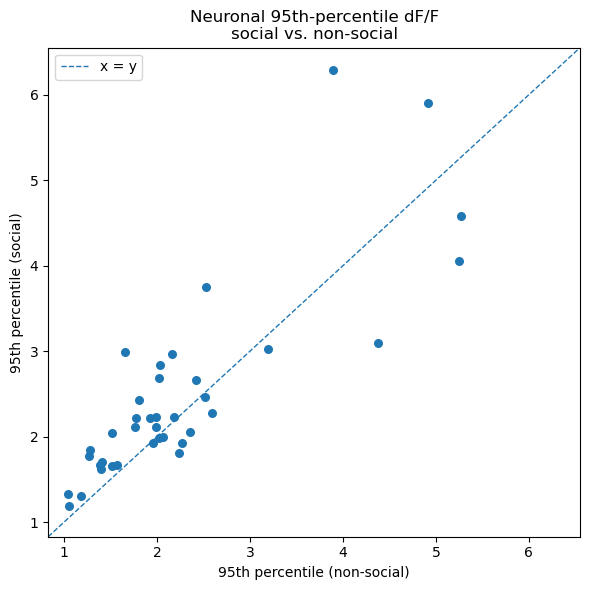

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_social_vs_non(csv_path):
    # 1. load your results
    df = pd.read_csv(csv_path, index_col=0)

    # 2. scatter each neuron
    x = df['95th_non_social'].values
    y = df['95th_social'].values
    neurons = df.index.tolist()

    # 3. plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x, y, s=30)
    # identity line
    lims = [
        np.nanmin([ax.get_xlim(), ax.get_ylim()]), 
        np.nanmax([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, '--', linewidth=1, label='x = y')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel('95th percentile (non-social)')
    ax.set_ylabel('95th percentile (social)')
    ax.set_title('Neuronal 95th-percentile dF/F\nsocial vs. non-social')
    ax.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_social_vs_non.csv"
    plot_social_vs_non(csv_path)


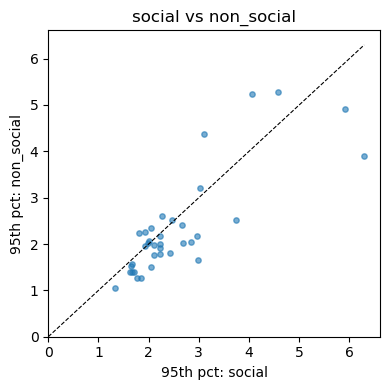

/tmp/ipykernel_2962754/1473681041.py:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,4))


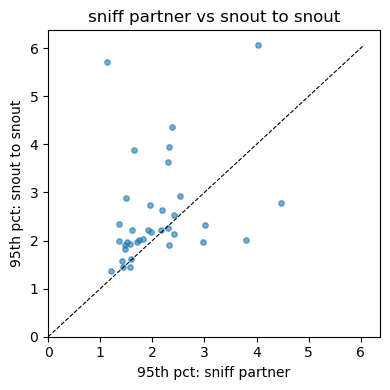

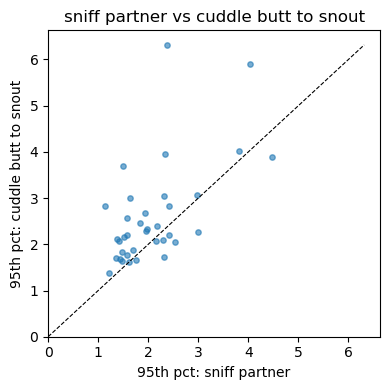

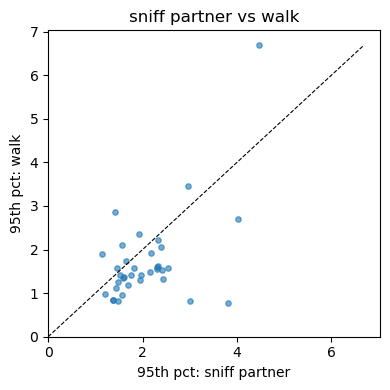

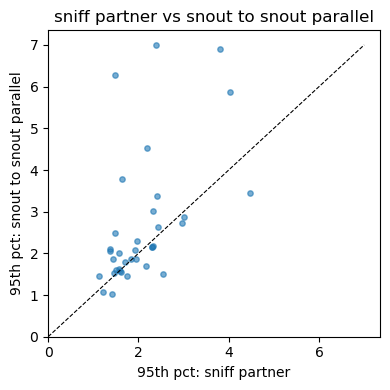

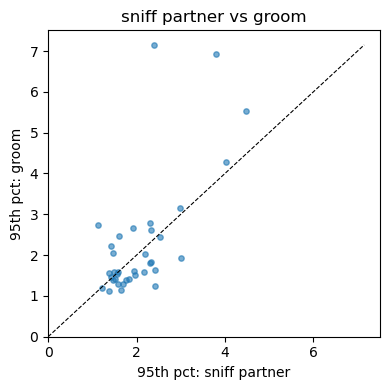

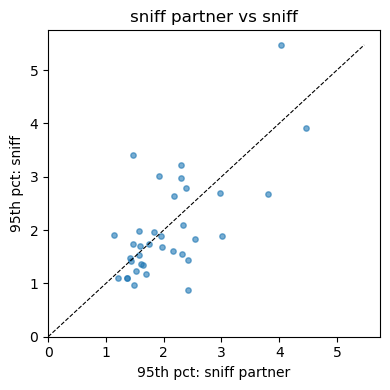

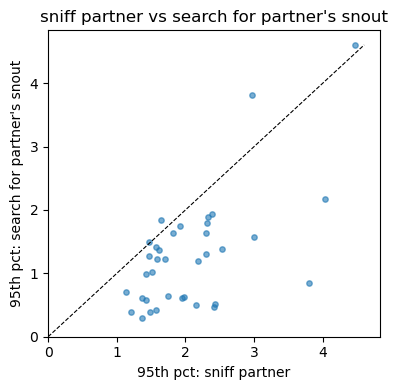

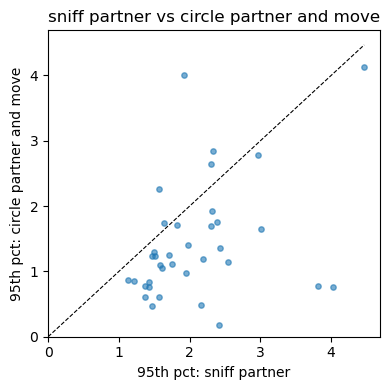

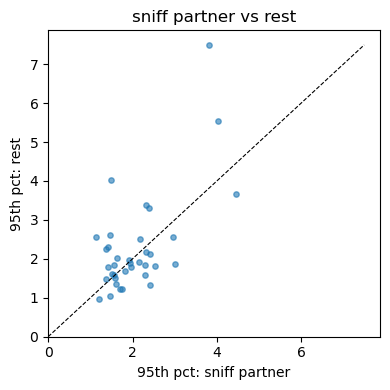

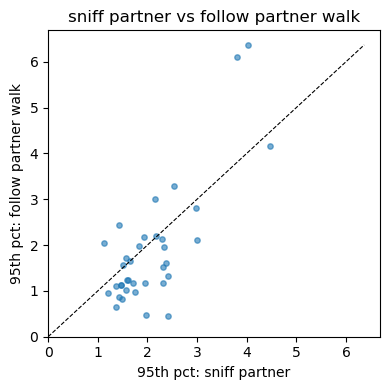

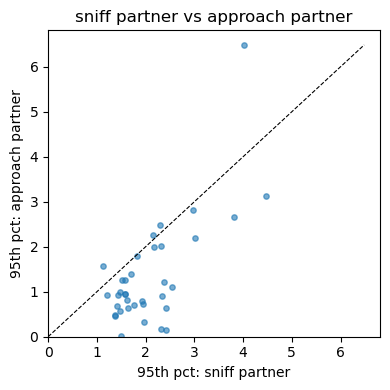

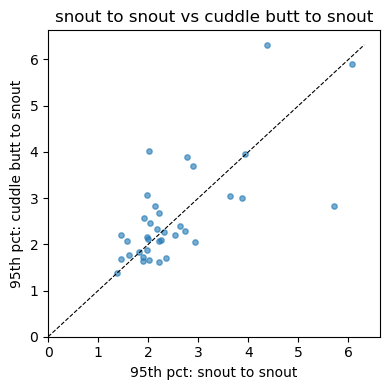

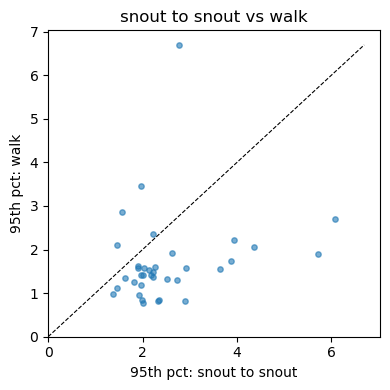

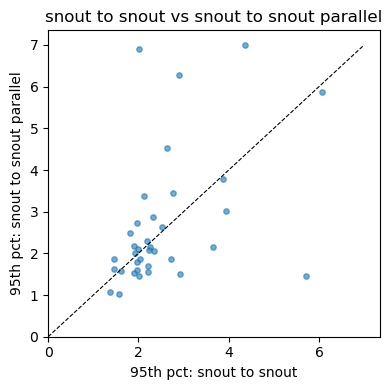

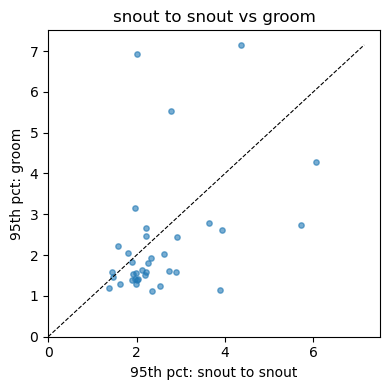

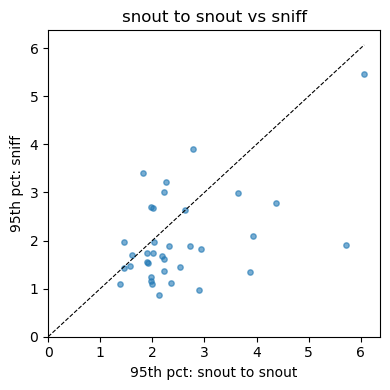

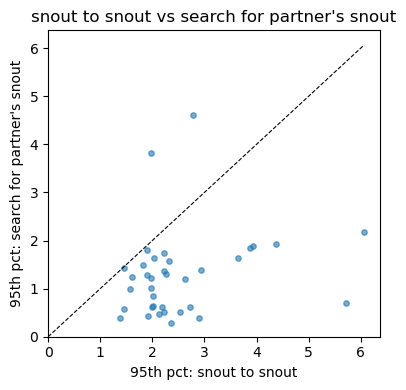

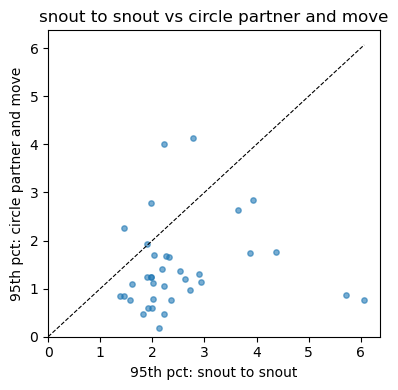

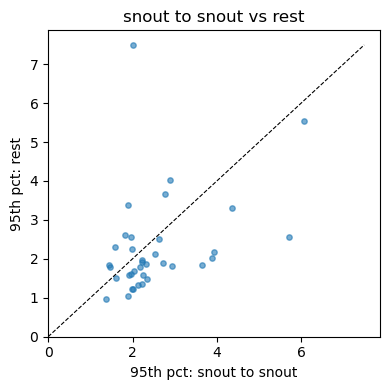

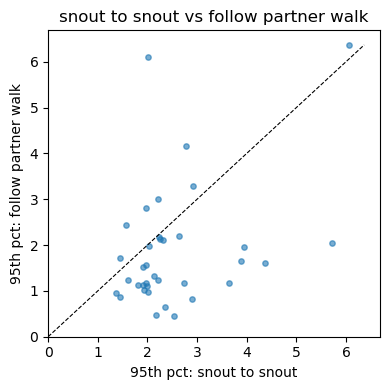

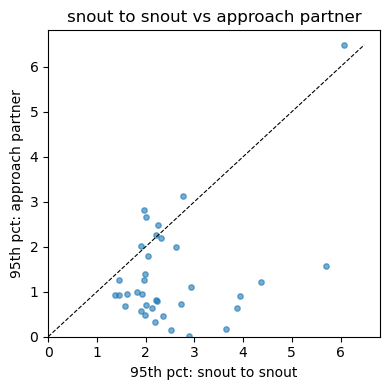

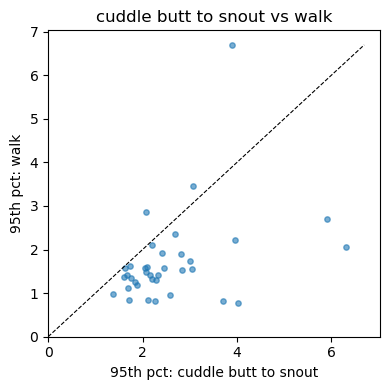

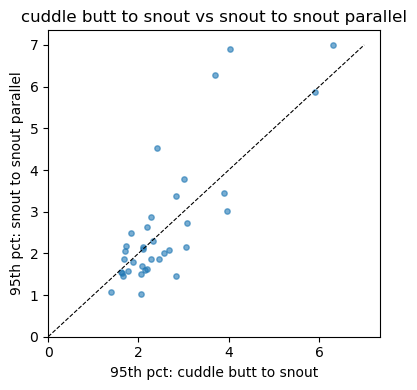

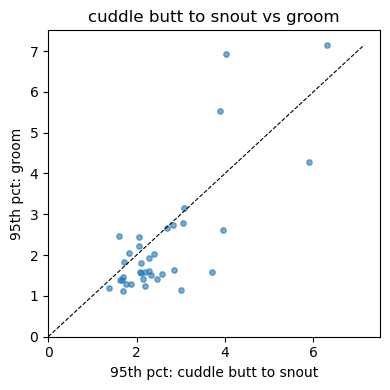

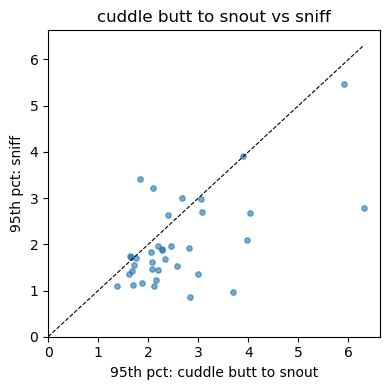

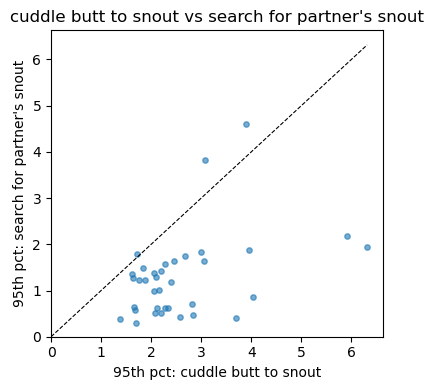

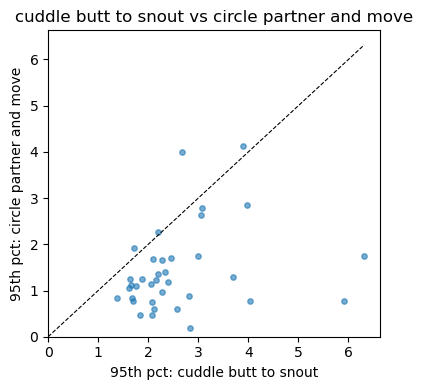

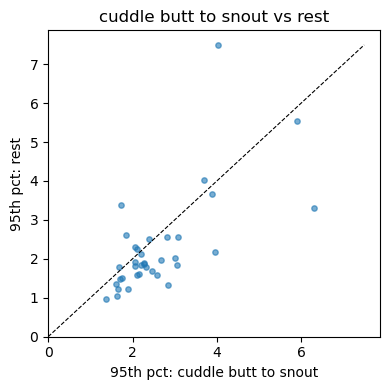

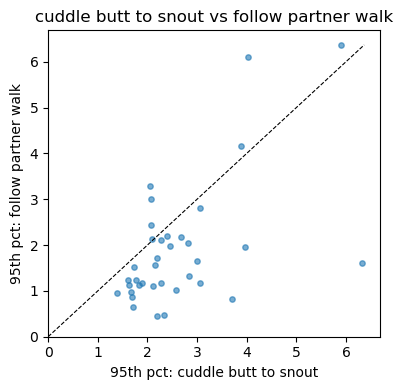

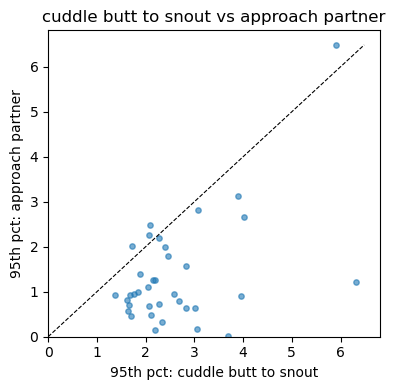

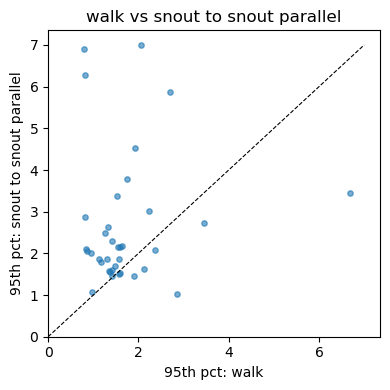

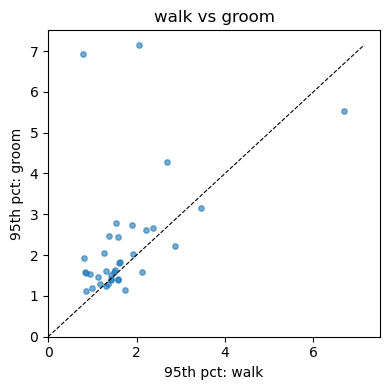

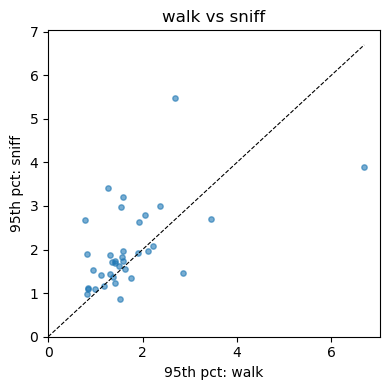

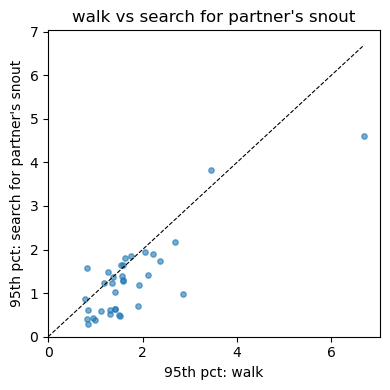

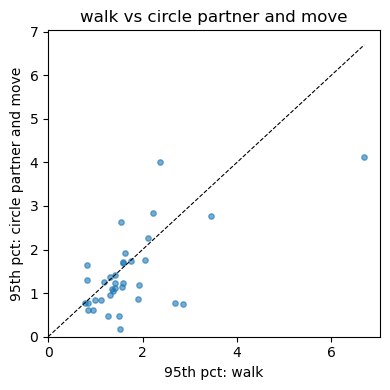

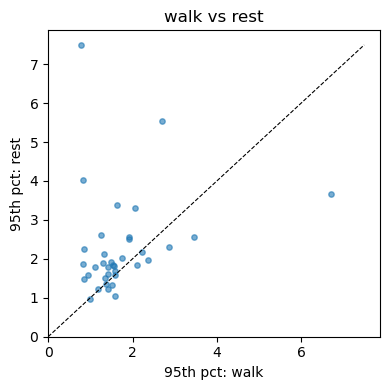

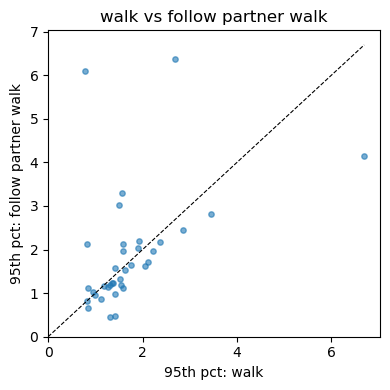

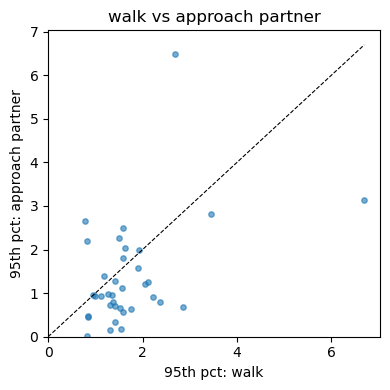

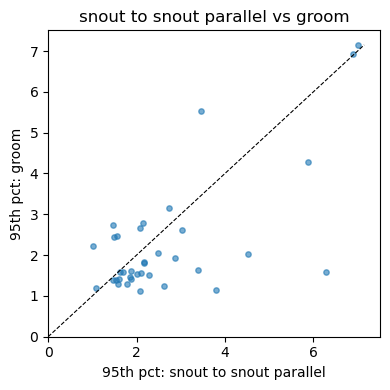

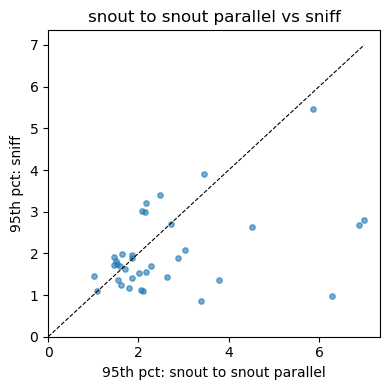

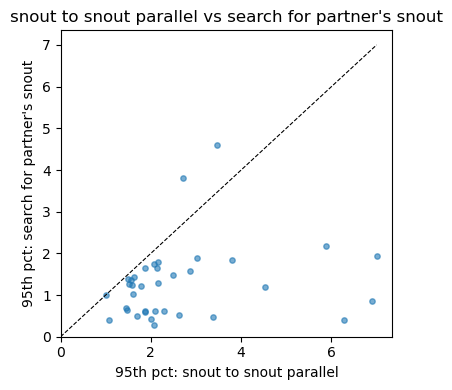

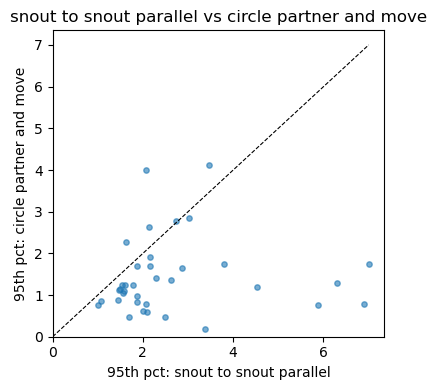

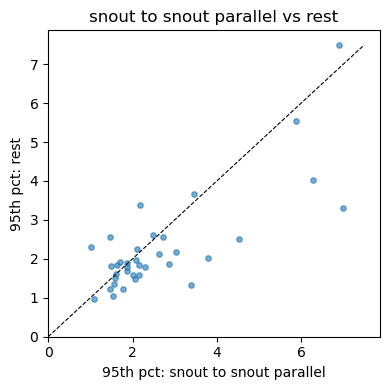

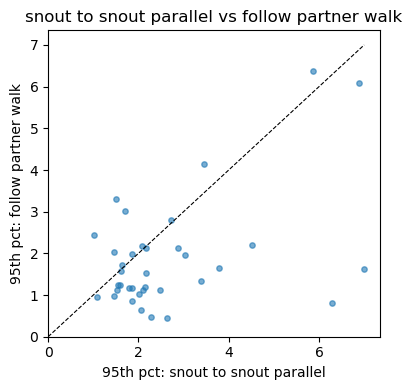

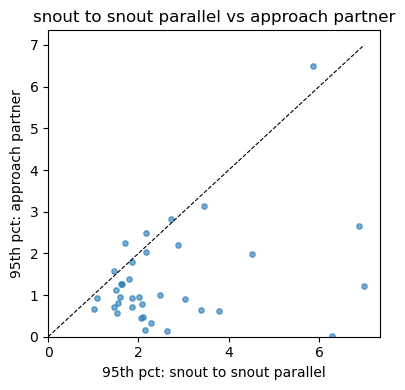

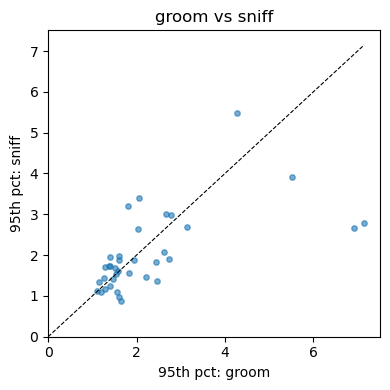

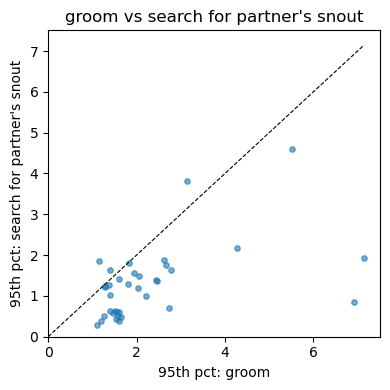

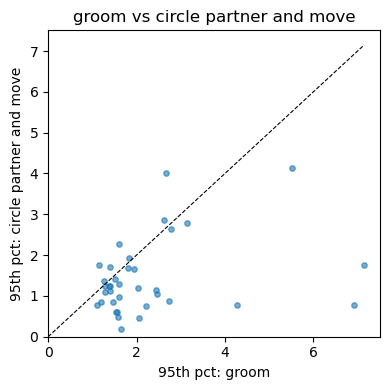

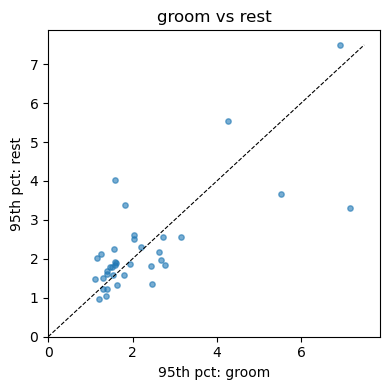

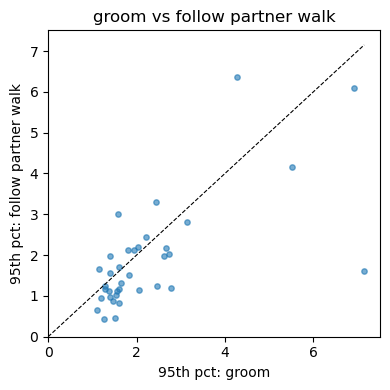

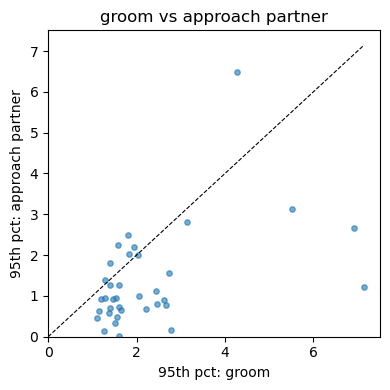

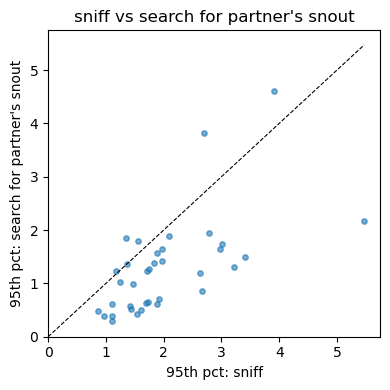

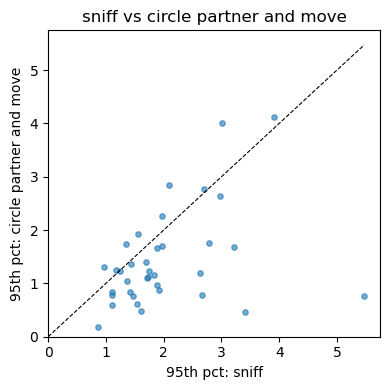

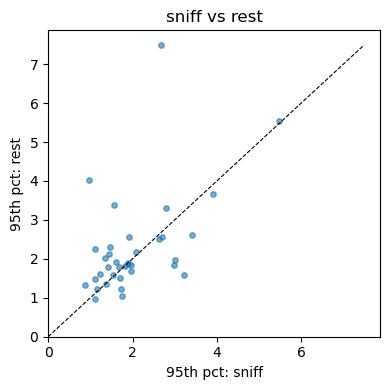

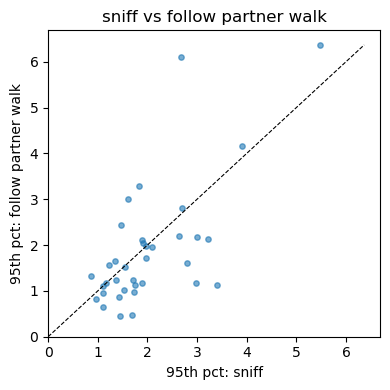

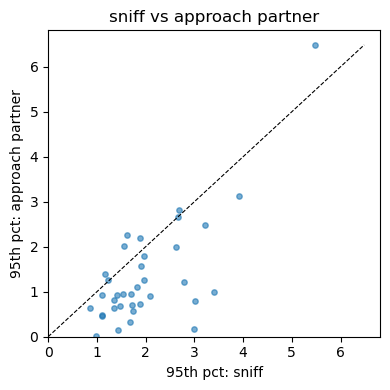

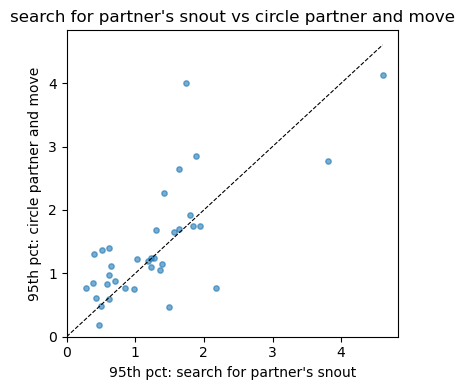

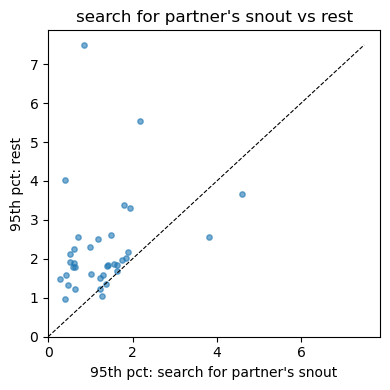

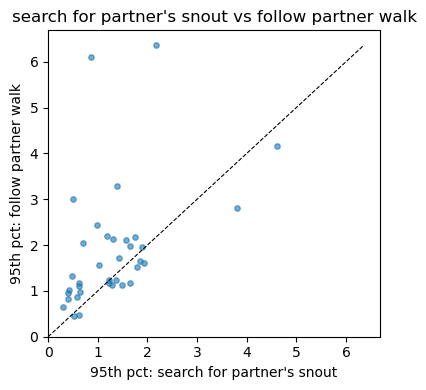

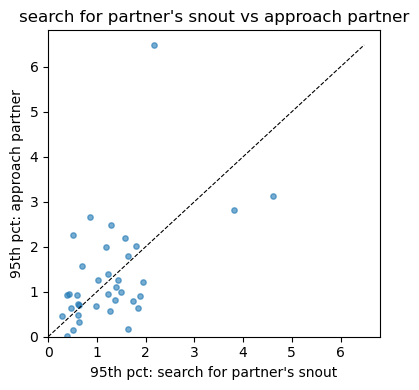

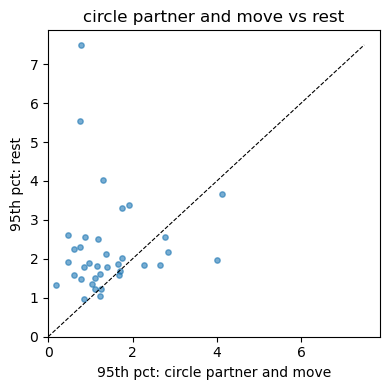

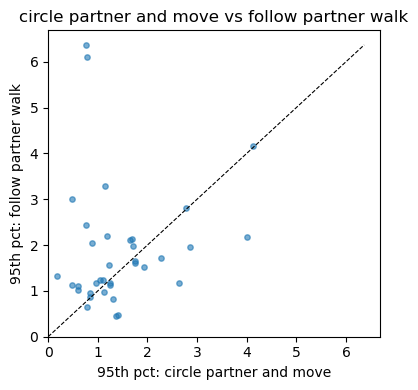

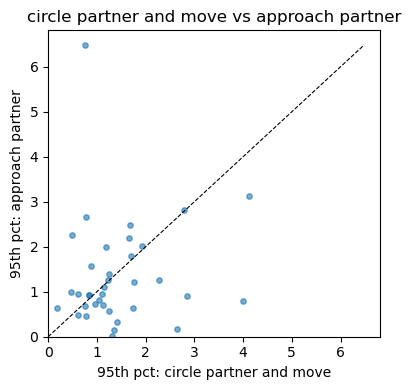

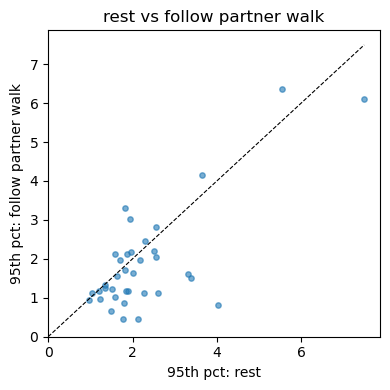

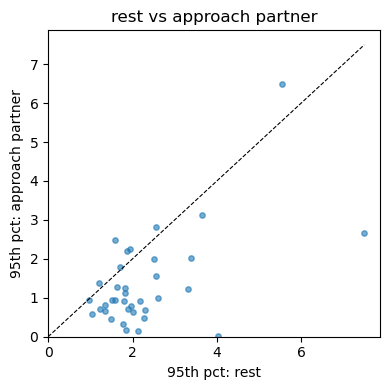

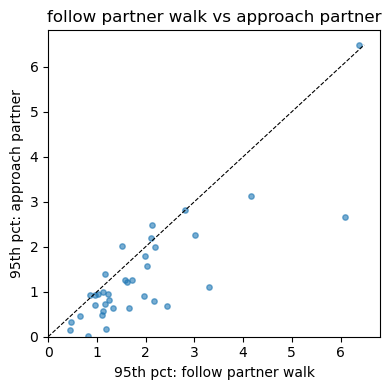

In [38]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# Re-use your existing exclusion & loading logic
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key,val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    files = glob.glob(os.path.join(h5_dir, '*aligned_predictions_with_ca_and_dF_F*.h5'))
    if not files:
        raise FileNotFoundError(f"No .h5 in {h5_dir}")
    df = pd.read_hdf(files[0], key='df')
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    df = df.reset_index(drop=True)
    df['session_path'] = rec_path
    return df

def build_neuron_matrix_raw(df, exclude_dict):
    sess = df['session_path'].iat[0]
    excluded = get_excluded_neurons_for_session(sess, exclude_dict)
    all_cols = [c for c in df.columns if c.startswith('dF_F_roi')]
    keep = []
    for c in all_cols:
        # parse roi index from 'dF_F_roiXX'
        idx = int(c.split('_')[-1][3:])
        if idx not in excluded:
            keep.append(c)
    if not keep:
        return [], np.zeros((0, len(df)))
    mat = df[keep].values.T   # shape (n_roi, n_frames)
    vars_ = np.var(mat, axis=1)
    cutoff = np.percentile(vars_, 5) if vars_.size else 0
    mask = vars_ > cutoff
    return [keep[i] for i in range(len(keep)) if mask[i]], mat[mask]

# ----------------------------------------------------------------------------
# Compute percentiles by any grouping you like
# ----------------------------------------------------------------------------
def compute_percentiles_by_groups(
    rec_path,
    segments_csv,
    exclude_dict,
    group_col='sociality',
    groups=None,
    pct=95
):
    """
    rec_path      : one session folder
    segments_csv  : path to your labeled CSV (must have start_frame,end_frame, plus group_col)
    group_col     : either 'sociality' or 'label'
    groups        : list of values in segments_csv[group_col] to compare
    pct           : e.g. 80, 90, 95
    """
    df     = load_session_data(rec_path)
    df     = df.reset_index(drop=True)
    rois, M = build_neuron_matrix_raw(df, exclude_dict)
    if M.size == 0:
        raise RuntimeError("No ROIs left after exclusion/variance filtering")

    seg = pd.read_csv(segments_csv)
    if group_col not in seg.columns:
        raise KeyError(f"{group_col} not in your segments CSV")

    # fill missing frame‐numbers
    seg['start_frame'] = pd.to_numeric(seg['start_frame'], errors='coerce')
    seg['end_frame']   = pd.to_numeric(seg['end_frame'],   errors='coerce')
    minf = int(df['camera_frame_sixcam'].min())
    maxf = int(df['camera_frame_sixcam'].max())
    seg['start_frame'] = seg['start_frame'].fillna(minf).astype(int)
    seg['end_frame']   = seg['end_frame'].fillna(maxf).astype(int)

    if groups is None:
        groups = seg[group_col].dropna().unique().tolist()

    # build a mask per group, compute percentile
    out = pd.DataFrame(index=rois, columns=groups, dtype=float)
    for g in groups:
        mask = pd.Series(False, index=df.index)
        for _, row in seg[seg[group_col] == g].iterrows():
            m = (
                (df['camera_frame_sixcam'] >= row['start_frame']) &
                (df['camera_frame_sixcam'] <= row['end_frame'])
            )
            mask |= m
        if mask.any():
            out[g] = np.nanpercentile(M[:, mask.values], pct, axis=1)
        else:
            out[g] = np.nan

    return out

# ----------------------------------------------------------------------------
# Immediately plot *all* pairwise scatter‐comparisons among your chosen groups
# ----------------------------------------------------------------------------
import itertools
def plot_all_pairs(percentiles_df, pct):
    groups = percentiles_df.columns.tolist()
    for a,b in itertools.combinations(groups, 2):
        x = percentiles_df[a].values
        y = percentiles_df[b].values
        # drop any NaN
        valid = ~np.isnan(x) & ~np.isnan(y)
        if not valid.any():
            continue

        mm = max(x[valid].max(), y[valid].max())
        plt.figure(figsize=(4,4))
        plt.scatter(x[valid], y[valid], s=15, alpha=0.6)
        plt.plot([0,mm],[0,mm],'k--', lw=0.8)
        plt.xlabel(f"{pct}th pct: {a}", fontsize=10)
        plt.ylabel(f"{pct}th pct: {b}", fontsize=10)
        plt.title(f"{a} vs {b}", fontsize=12)
        plt.xlim(0, mm*1.05)
        plt.ylim(0, mm*1.05)
        plt.tight_layout()

    plt.show()


# ----------------------------------------------------------------------------
# Example: do it for one session, choose percentile & grouping
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_path   = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
    segments_csv   = "/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv"
    pct           = 95                        # ← pick 80, 90, 95, whatever
    # 1) compare social vs non_social:
    df_pct1 = compute_percentiles_by_groups(
        session_path,
        segments_csv,
        exclude_mapping,
        group_col='sociality',
        groups=['social','non_social'],
        pct=pct
    )
    plot_all_pairs(df_pct1, pct)

    # 2) compare all your behavior‐labels at once:
    labels = pd.read_csv(segments_csv)['label'].dropna().unique().tolist()
    df_pct2 = compute_percentiles_by_groups(
        session_path,
        segments_csv,
        exclude_mapping,
        group_col='label',
        groups=labels,
        pct=pct
    )
    plot_all_pairs(df_pct2, pct)


In [43]:
from scipy.stats import f_oneway

# df_pct2: DataFrame of shape (n_rois, n_behaviors), e.g. columns=['A','B','C','D','E']
csv_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33/neuron_95th_by_category.csv"
df_pct2 = pd.read_csv(csv_path, index_col=0)

p_anova = []
for roi in df_pct2.index:
    vals = [ df_pct2.loc[roi, cat] for cat in df_pct2.columns ]
    # drop NaNs
    vals = [v for v in vals if not np.isnan(v)]
    # you need at least 2 non‐NaN groups
    if len(vals) < 2:
        p_anova.append(np.nan)
    else:
        _, p_anova_val = f_oneway(*[ [df_pct2.loc[roi, c]] for c in df_pct2.columns if not np.isnan(df_pct2.loc[roi,c])] )
        p_anova.append(p_anova_val)

df_anova = pd.DataFrame({'p_anova': p_anova}, index=df_pct2.index)
print(df_anova.sort_values('p_anova').head(10))


           p_anova
dF_F_roi0      NaN
dF_F_roi1      NaN
dF_F_roi2      NaN
dF_F_roi3      NaN
dF_F_roi4      NaN
dF_F_roi5      NaN
dF_F_roi6      NaN
dF_F_roi7      NaN
dF_F_roi8      NaN
dF_F_roi9      NaN


/home/lq53/miniconda3/envs/bbop241209_clone/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


In [46]:
import os
import glob
import json
import numpy as np
import pandas as pd
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing   import StandardScaler

# ----------------------------------------------------------------------------
# 1. load one session’s data + labels
# ----------------------------------------------------------------------------
def find_aligned_h5(session_path):
    # 1) look in MIR_Aligned
    p1 = glob.glob(os.path.join(session_path, 'MIR_Aligned', '*aligned_predictions_with_ca_and_dF_F*.h5'))
    if p1:
        return p1[0]
    # 2) fallback: search anywhere under session_path
    p2 = glob.glob(os.path.join(session_path, '**', '*aligned_predictions_with_ca_and_dF_F*.h5'),
                   recursive=True)
    if p2:
        return p2[0]
    raise FileNotFoundError(f"No aligned_predictions_with_ca_and_dF_F*.h5 found under {session_path!r}")

def load_features_and_labels(session_path, segments_csv, label_col='label_remapped'):
    # find and load the HDF5
    h5_file = find_aligned_h5(session_path)
    df = pd.read_hdf(h5_file, key='df')
    df = df.reset_index()  # bring timestamp_ms_mini into a column if it was index

    # features: all dF_F_roi*
    roi_cols = [c for c in df.columns if c.startswith('dF_F_roi')]
    if not roi_cols:
        raise ValueError("No dF_F_roi* columns found in the HDF5!")

    X = df[roi_cols].values  # shape (n_frames, n_rois)

    # load segments and build per-frame labels
    seg = pd.read_csv(segments_csv)
    if label_col not in seg.columns:
        raise KeyError(f"Column {label_col!r} not found in {segments_csv}")

    # parse frame bounds
    seg['start_frame'] = pd.to_numeric(seg['start_frame'], errors='coerce').fillna(0).astype(int)
    seg['end_frame']   = pd.to_numeric(seg['end_frame'],   errors='coerce').fillna(len(df)-1).astype(int)

    # initialize all frames as unlabeled
    y = np.array(['_'] * len(df), dtype=object)

    for _, row in seg.iterrows():
        lab = row[label_col]
        if pd.isna(lab):
            continue
        f0, f1 = row['start_frame'], row['end_frame']
        # clip to valid range
        f0 = max(0, min(len(df)-1, f0))
        f1 = max(0, min(len(df)-1, f1))
        y[f0:f1+1] = lab

    # drop unlabeled frames
    mask = y != '_'
    X_labeled = X[mask]
    y_labeled = y[mask]

    if len(y_labeled) == 0:
        raise RuntimeError("No frames got a label—check your segments CSV and frame indices.")

    return X_labeled, y_labeled
# ----------------------------------------------------------------------------
# 2. standardize, train & cross-validate
# ----------------------------------------------------------------------------
def decode_behaviors(X, y, clf, cv=5):
    """
    X: array (n_samples, n_features)
    y: array of labels (n_samples,)
    clf: instantiated classifier (LogisticRegression or SVC)
    returns: array of cv accuracies
    """
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    skf    = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    scores = cross_val_score(clf, Xs, y, cv=skf, scoring='accuracy')
    return scores

if __name__ == '__main__':
    session_path   = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
    segments_csv   = "/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv"
 # choose which label column: e.g. 'sociality' or 'label_remapped'
    label_col    = 'sociality'  
    pct          = 95            # this only affects your segments file if you re-generate it

    # load features & labels
    X, y = load_features_and_labels(session_path, segments_csv, label_col)

    # train/test: social vs non_social  (binary)
    logreg = LogisticRegression(max_iter=500)
    svm    = SVC(kernel='linear')

    scores_lr = decode_behaviors(X, y, logreg, cv=5)
    scores_svm= decode_behaviors(X, y, svm,    cv=5)

    print(f"\nDecoding '{label_col}' (n_samples={len(y)})")
    print(f" Logistic Regression accuracy: {scores_lr.mean():.3f} ± {scores_lr.std():.3f}")
    print(f" SVM (linear)             : {scores_svm.mean():.3f} ± {scores_svm.std():.3f}")

    # if you want multi-class (all labels) simply set label_col='label_remapped'
    # and rerun, the code handles any number of classes automatically.



Decoding 'sociality' (n_samples=6721)
 Logistic Regression accuracy: 0.871 ± 0.004
 SVM (linear)             : 0.854 ± 0.002


In [47]:
import os
import glob
import json
import numpy as np
import pandas as pd
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing   import StandardScaler

# ----------------------------------------------------------------------------
# 1. load one session’s data + labels
# ----------------------------------------------------------------------------
def find_aligned_h5(session_path):
    # 1) look in MIR_Aligned
    p1 = glob.glob(os.path.join(session_path, 'MIR_Aligned', '*aligned_predictions_with_ca_and_dF_F*.h5'))
    if p1:
        return p1[0]
    # 2) fallback: search anywhere under session_path
    p2 = glob.glob(os.path.join(session_path, '**', '*aligned_predictions_with_ca_and_dF_F*.h5'),
                   recursive=True)
    if p2:
        return p2[0]
    raise FileNotFoundError(f"No aligned_predictions_with_ca_and_dF_F*.h5 found under {session_path!r}")

def load_features_and_labels(session_path, segments_csv, label_col='label_remapped'):
    # find and load the HDF5
    h5_file = find_aligned_h5(session_path)
    df = pd.read_hdf(h5_file, key='df')
    df = df.reset_index()  # bring timestamp_ms_mini into a column if it was index

    # features: all dF_F_roi*
    roi_cols = [c for c in df.columns if c.startswith('dF_F_roi')]
    if not roi_cols:
        raise ValueError("No dF_F_roi* columns found in the HDF5!")

    X = df[roi_cols].values  # shape (n_frames, n_rois)

    # load segments and build per-frame labels
    seg = pd.read_csv(segments_csv)
    if label_col not in seg.columns:
        raise KeyError(f"Column {label_col!r} not found in {segments_csv}")

    # parse frame bounds
    seg['start_frame'] = pd.to_numeric(seg['start_frame'], errors='coerce').fillna(0).astype(int)
    seg['end_frame']   = pd.to_numeric(seg['end_frame'],   errors='coerce').fillna(len(df)-1).astype(int)

    # initialize all frames as unlabeled
    y = np.array(['_'] * len(df), dtype=object)

    for _, row in seg.iterrows():
        lab = row[label_col]
        if pd.isna(lab):
            continue
        f0, f1 = row['start_frame'], row['end_frame']
        # clip to valid range
        f0 = max(0, min(len(df)-1, f0))
        f1 = max(0, min(len(df)-1, f1))
        y[f0:f1+1] = lab

    # drop unlabeled frames
    mask = y != '_'
    X_labeled = X[mask]
    y_labeled = y[mask]

    if len(y_labeled) == 0:
        raise RuntimeError("No frames got a label—check your segments CSV and frame indices.")

    return X_labeled, y_labeled
# ----------------------------------------------------------------------------
# 2. standardize, train & cross-validate
# ----------------------------------------------------------------------------
def decode_behaviors(X, y, clf, cv=5):
    """
    X: array (n_samples, n_features)
    y: array of labels (n_samples,)
    clf: instantiated classifier (LogisticRegression or SVC)
    returns: array of cv accuracies
    """
    scaler = StandardScaler()
    Xs     = scaler.fit_transform(X)
    skf    = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    scores = cross_val_score(clf, Xs, y, cv=skf, scoring='accuracy')
    return scores

if __name__ == '__main__':
    session_path   = "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33"
    segments_csv   = "/home/lq53/mir_repos/BBOP/random_tests/25may_social_try/Continuous_Labeled_Segments.csv"
 # choose which label column: e.g. 'sociality' or 'label_remapped'
    label_col    = "label" #'sociality'  
    pct          = 95            # this only affects your segments file if you re-generate it

    # load features & labels
    X, y = load_features_and_labels(session_path, segments_csv, label_col)

    # train/test: social vs non_social  (binary)
    logreg = LogisticRegression(max_iter=500)
    svm    = SVC(kernel='linear')

    scores_lr = decode_behaviors(X, y, logreg, cv=5)
    scores_svm= decode_behaviors(X, y, svm,    cv=5)

    print(f"\nDecoding '{label_col}' (n_samples={len(y)})")
    print(f" Logistic Regression accuracy: {scores_lr.mean():.3f} ± {scores_lr.std():.3f}")
    print(f" SVM (linear)             : {scores_svm.mean():.3f} ± {scores_svm.std():.3f}")

    # if you want multi-class (all labels) simply set label_col='label_remapped'
    # and rerun, the code handles any number of classes automatically.



Decoding 'label' (n_samples=6721)
 Logistic Regression accuracy: 0.713 ± 0.008
 SVM (linear)             : 0.750 ± 0.007
